In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate

In [2]:
random_seed = 108
test_size = 0.2

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)[:,1]
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba)]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [4]:
test_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})

In [5]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')

In [6]:
# excluded efgr as derivative of creatinine
# 
cols = ['age','sex','healthcare_worker','hypertension',
        'hypercholesterolemia',
       'diabetes' ,'smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','troponin_uln',
         #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
        'coronary_med_history_col']

# get rid of past medical_history
# 'fio2','po2','pco2'

coronary_med_history_col = [
    'coronary_artery_disease',
    'heart_failure_cardiomyopathy',
    'af_flutter',
    'severe_valvular_disease',
    'stroke_tia',
    'pad']

cardio_complication = [
    'pericarditis',
    'new_2nd_degree_heart_block',
    'new_3rd_degree_heart_block',
    'conscious_sustained_vt',
    'new_cardiomyopathy_hf',
    'new_af_flutter',
    'myocarditis_myopericarditis',
    'pulm_embolus',
    'cardiac_arrest'
]

# replace No's to 0
for col in coronary_med_history_col + cardio_complication + ['past_medical_history']:
    df[col] = df[col].replace(2, 0)


df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]
df['coronary_med_history_col'] = df[coronary_med_history_col].any(axis=1)


categorical_col = ['sex','healthcare_worker','hypertension',
        'hypercholesterolemia','diabetes', 'smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln',
                     #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
             'coronary_med_history_col']



predictor = ['intubation_dummy','death','cardio_complication']

df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]
df['cardio_complication'] = df[cardio_complication].any(axis=1).astype(float)


data_predictor = df[predictor]
data = df[cols+predictor]

In [7]:
float_col = ['height','sbp','dbp','heart_rate','weight','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous',]
int_col = ['age']

In [8]:
data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_24460\935426440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)


In [73]:
df_dummy =  pd.get_dummies(
        data,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [75]:
dummy_col_names = df_dummy.columns.difference(data.columns).tolist()

In [81]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_dummy, test_size=test_size, random_state=random_seed)


In [82]:
chosen_model = {
    'death': ['l1_feature_selection5_oversample','l1'],
    'intubation_dummy': ['elasticnet_feature_selection5_oversample','EN'],
    'cardio_complication': ['elasticnet_feature_selection5_oversample','EN']
}

In [83]:
pd.DataFrame(columns = test.drop(predictor, axis=1).columns).to_csv("dataframe_template.csv")

In [84]:
df_dummy.shape

(1714, 41)

In [85]:
train.shape

(1371, 41)

In [86]:
test.shape

(343, 41)

In [87]:
predictor

['intubation_dummy', 'death', 'cardio_complication']

In [88]:
cont_describe = data[float_col+int_col].describe()

In [89]:
cont_describe = pd.concat([cont_describe,pd.DataFrame(data[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe.loc['NA_perc',:] = cont_describe.loc['NA',:]/data.shape[0]*100

In [90]:
cont_describe

height          sbp          dbp   heart_rate      weight  \
count     614.000000  1627.000000  1563.000000  1662.000000  842.000000   
mean      169.025098   130.825446    75.937940    91.676294   83.243575   
std        15.382989    22.290247    13.013265    18.200632   22.477981   
min         1.750000    70.000000    35.000000    31.000000    7.000000   
25%       163.000000   115.000000    69.000000    79.000000   68.625000   
50%       170.000000   130.000000    76.000000    90.000000   80.000000   
75%       177.000000   145.000000    84.000000   103.000000   94.575000   
max       200.000000   233.000000   150.000000   169.000000  250.000000   
NA       1100.000000    87.000000   151.000000    52.000000  872.000000   
NA_perc    64.177363     5.075846     8.809802     3.033839   50.875146   

         respiratory_rate  temperature         spo2          crp  lymphocytes  \
count         1642.000000  1600.000000  1576.000000  1426.000000  1628.000000   
mean            23.010353    37.412194    94.317259    69.306311     1.279275   
std              6.815798     2.032940     5.225175    71.962239     3.116125   
min             11.000000    26.400000    30.000000     0.400000     0.000000   
25%             18.000000    36.600000    93.000000    16.000000     0.700000   
50%             21.000000    37.300000    96.000000    47.000000     1.000000   
75%             26.000000    38.000000    97.000000    97.000000     1.400000   
max             96.000000    99.000000   100.000000   469.000000   114.300000   
NA              72.000000   114.000000   138.000000   288.000000    86.000000   
NA_perc          4.200700     6.651109     8.051342    16.802800     5.017503   

         ...    platelets      albumin          ldh     d_dimer      ferritin  \
count    ...  1630.000000  1495.000000   825.000000  850.000000    784.000000   
mean     ...   216.684663    34.265645   355.506545    1.529095    920.203941   
std      ...   145.772151    11.080534   194.677898    6.091416   1378.932321   
min      ...     4.000000     0.340000     1.200000    0.001060      0.230000   
25%      ...   153.000000    31.000000   237.000000    0.470000    228.000000   
50%      ...   198.000000    34.000000   308.000000    0.720000    513.000000   
75%      ...   254.000000    37.000000   427.000000    1.170000   1066.750000   
max      ...  3354.000000   354.000000  2026.000000  152.250000  17642.000000   
NA       ...    84.000000   219.000000   889.000000  864.000000    930.000000   
NA_perc  ...     4.900817    12.777130    51.866978   50.408401     54.259043   

         haemoglobin   creatinine          alt  lactate_venous          age  
count    1633.000000  1635.000000  1439.000000      753.000000  1714.000000  
mean      133.234415    97.465627    43.324670        2.292244    60.101517  
std        19.451262    90.505991    53.618129       12.717740    20.625993  
min         5.300000     2.700000     1.300000        0.070000    18.000000  
25%       123.000000    63.000000    19.000000        1.100000    43.000000  
50%       134.000000    78.000000    29.000000        1.400000    62.000000  
75%       146.000000    99.500000    48.000000        1.800000    78.000000  
max       201.000000  1254.000000   810.000000      265.000000   101.000000  
NA         81.000000    79.000000   275.000000      961.000000     0.000000  
NA_perc     4.725788     4.609102    16.044341       56.067678     0.000000  

[10 rows x 21 columns]

In [21]:
cont_describe_train = train[float_col+int_col].describe()
cont_describe_train = pd.concat([cont_describe_train,pd.DataFrame(train[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe_train.loc['NA_perc',:] = cont_describe_train.loc['NA',:]/train.shape[0]*100

In [22]:
cont_describe_test = test[float_col+int_col].describe()
cont_describe_test = pd.concat([cont_describe_test,pd.DataFrame(test[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe_test.loc['NA_perc',:] = cont_describe_test.loc['NA',:]/test.shape[0]*100

In [23]:
cont_describe_train

height          sbp          dbp   heart_rate      weight  \
count    510.000000  1302.000000  1249.000000  1327.000000  692.000000   
mean     168.781471   130.314900    75.703763    91.636021   82.442919   
std       15.946091    22.143771    12.935317    18.234214   21.426753   
min        1.750000    70.000000    35.000000    44.000000    7.000000   
25%      163.000000   115.000000    69.000000    79.000000   68.000000   
50%      170.000000   129.000000    76.000000    90.000000   80.000000   
75%      177.000000   144.000000    84.000000   103.000000   93.000000   
max      200.000000   233.000000   150.000000   169.000000  176.400000   
NA       861.000000    69.000000   122.000000    44.000000  679.000000   
NA_perc   62.800875     5.032823     8.898614     3.209336   49.525894   

         respiratory_rate  temperature         spo2          crp  lymphocytes  \
count         1311.000000  1282.000000  1261.000000  1130.000000  1302.000000   
mean            22.881770    37.419969    94.306899    70.374779     1.323026   
std              6.595203     2.212876     5.300362    73.467044     3.458140   
min             11.000000    26.400000    30.000000     0.400000     0.000000   
25%             18.000000    36.600000    93.000000    16.000000     0.700000   
50%             21.000000    37.300000    96.000000    48.000000     1.000000   
75%             26.000000    38.000000    97.000000    98.000000     1.400000   
max             60.000000    99.000000   100.000000   469.000000   114.300000   
NA              60.000000    89.000000   110.000000   241.000000    69.000000   
NA_perc          4.376368     6.491612     8.023341    17.578410     5.032823   

         ...    platelets      albumin          ldh     d_dimer      ferritin  \
count    ...  1304.000000  1194.000000   654.000000  675.000000    625.000000   
mean     ...   218.000000    34.189397   354.255199    1.398890    922.932624   
std      ...   157.518526    11.194252   201.193478    3.434882   1350.191855   
min      ...     4.000000     0.340000     1.200000    0.001060      0.230000   
25%      ...   153.000000    31.000000   233.500000    0.470000    239.000000   
50%      ...   199.000000    34.000000   307.500000    0.730000    533.000000   
75%      ...   254.250000    37.000000   422.000000    1.150000   1074.000000   
max      ...  3354.000000   354.000000  2026.000000   49.720000  17642.000000   
NA       ...    67.000000   177.000000   717.000000  696.000000    746.000000   
NA_perc  ...     4.886944    12.910284    52.297593   50.765864     54.412837   

         haemoglobin   creatinine          alt  lactate_venous          age  
count    1306.000000  1304.000000  1144.000000      610.000000  1371.000000  
mean      132.806126    97.199080    42.477448        2.425836    60.296134  
std        19.246544    89.155399    53.208991       14.100840    20.577746  
min         5.300000     3.600000     1.300000        0.070000    18.000000  
25%       122.000000    63.000000    19.000000        1.100000    43.000000  
50%       134.000000    78.000000    29.000000        1.400000    62.000000  
75%       145.000000    99.000000    48.000000        1.800000    78.000000  
max       196.000000  1182.000000   810.000000      265.000000   101.000000  
NA         65.000000    67.000000   227.000000      761.000000     0.000000  
NA_perc     4.741065     4.886944    16.557257       55.506929     0.000000  

[10 rows x 21 columns]

In [24]:
final_describe = pd.concat(dict(total = cont_describe.T, train = cont_describe_train.T,test=cont_describe_test.T),axis=1)

In [59]:
final_describe.to_csv("result/data/continuous_variable_summary.csv")

In [67]:
for c in categorical_col+predictor:
    df_sub = pd.concat([
        df[c].value_counts(dropna=False),
        df[c].value_counts(dropna=False,normalize=True)*100,
        train[c].value_counts(dropna=False).rename('train_count'),
        train[c].value_counts(dropna=False,normalize=True).rename('train_proportion')*100,
        test[c].value_counts(dropna=False).rename('test_count'),
        test[c].value_counts(dropna=False,normalize=True).rename('test_proportion')*100,
    ]
    ,axis=1).sort_index()
    df_sub.to_csv("result/data/" + c + "_summary.csv")

In [68]:
df_sub

count  proportion  train_count  train_proportion  \
cardio_complication                                                     
0.0                   1624   94.749125         1297          94.60248   
1.0                     90    5.250875           74           5.39752   

                     test_count  test_proportion  
cardio_complication                               
0.0                         327        95.335277  
1.0                          16         4.664723

# Stationary analysis

In [91]:
df_date = pd.concat([df_dummy,df['admission_date']],axis=1).rename(columns={0:'admission_date'})

In [92]:
date_describe = df_date['admission_date'].describe()
date_describe = pd.concat([date_describe,pd.DataFrame([df_date['admission_date'].isna().sum()]).T]).rename(index={0:'NA'})
date_describe.loc['NA_perc',:] = date_describe.loc['NA',:]/df_date.shape[0]*100
print(date_describe)

                                     0
count                              838
mean     2021-10-26 02:36:22.338902016
min                2020-09-04 00:00:00
25%                2021-09-13 00:00:00
50%                2021-09-29 00:00:00
75%                2021-12-29 00:00:00
max                2022-07-11 00:00:00
NA                                 876
NA_perc                      51.108518


In [ ]:
date_seg = [
    date_describe.loc['min',0],
    date_describe.loc['25%',0],
    date_describe.loc['50%',0],
    date_describe.loc['75%',0],
    date_describe.loc['max',0]]

In [94]:
df_date_non_null = df_date.query('admission_date.notnull()')

In [131]:
date_seg_third = [
    np.quantile(df_date_non_null['admission_date'],0),

    np.quantile(df_date_non_null['admission_date'],1/3),
    np.quantile(df_date_non_null['admission_date'],2.0/3.0),
    np.quantile(df_date_non_null['admission_date'],1.0)]
date_seg_third

[numpy.datetime64('2020-09-04T00:00:00.000000000'),
 numpy.datetime64('2021-09-18T00:00:00.000000000'),
 numpy.datetime64('2021-11-16T00:00:00.000000000'),
 numpy.datetime64('2022-07-11T00:00:00.000000000')]

In [95]:
min_date = np.nanmin(df_date_non_null['admission_date'])
max_date = np.nanmax(df_date_non_null['admission_date'])
print(min_date,max_date)

2020-09-04T00:00:00.000000000 2022-07-11T00:00:00.000000000


In [96]:
x = (max_date-min_date)/4
date_seg_2 = [min_date,min_date+x,min_date+2*x,min_date+3*x,max_date]
days = x.astype('timedelta64[D]')
days / np.timedelta64(1, 'D')

168.0

In [97]:
date_seg_2

[numpy.datetime64('2020-09-04T00:00:00.000000000'),
 numpy.datetime64('2021-02-19T18:00:00.000000000'),
 numpy.datetime64('2021-08-07T12:00:00.000000000'),
 numpy.datetime64('2022-01-23T06:00:00.000000000'),
 numpy.datetime64('2022-07-11T00:00:00.000000000')]

In [215]:
df_date_non_null.loc[:,'quarter'],bins=pd.cut(df_date_non_null['admission_date'],
                                         bins=date_seg, 
                                         labels=[1,2,3,4],
                                         right=True,
                                        include_lowest=True,
                                              retbins=True,
                                             precision=0)

In [216]:
df_date_non_null[['admission_date','quarter']]

admission_date quarter
38       2021-07-19       1
40       2021-07-24       1
45       2021-08-04       1
54       2021-08-15       1
69       2021-08-24       1
...             ...     ...
1625     2021-09-16       2
1626     2021-09-20       2
1627     2021-09-11       1
1628     2021-09-12       1
1629     2021-09-19       2

[838 rows x 2 columns]

In [217]:
df_date_summary = df_date_non_null['quarter'].value_counts().sort_index()
date_strings = [d.strftime('%d-%b-%Y') for d in bins]

In [218]:
pd.concat([pd.Series(date_strings),df_date_summary],ignore_index=True,axis=1).rename({0:'End Date',1:'count'},axis=1)

End Date  count
0  04-Sep-2020    NaN
1  13-Sep-2021  212.0
2  29-Sep-2021  210.0
3  29-Dec-2021  209.0
4  11-Jul-2022  207.0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

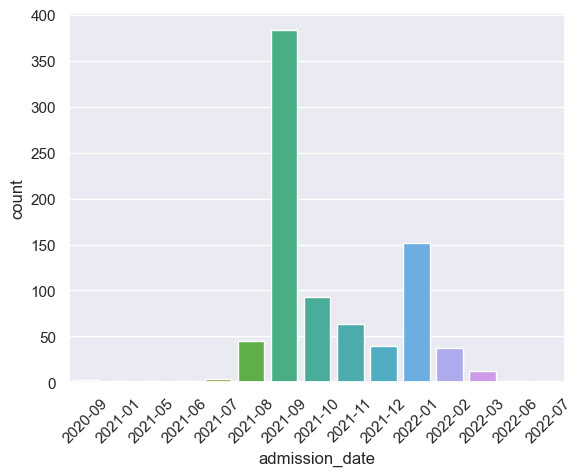

In [102]:
grouped = df_date_non_null.groupby(df_date_non_null["admission_date"].dt.strftime("%Y-%m")).size().reset_index(name
    = 'count')  
ax = sns.barplot(grouped,x='admission_date',y='count')
plt.setp(ax.get_xticklabels(), rotation=45)

### chi squared test for homogeneity

In [136]:
from scipy.stats import chi2_contingency

In [138]:
discrete_chi_test = pd.DataFrame({
    'variable':[],
    'chi2':[],
    'p':[],
    'dof':[],
    'reject':[]
})
alpha = 0.05
for var in predictor+dummy_col_names :  
    counts_df = np.array(df_date_non_null.groupby(['quarter',var])[var].count()).reshape((3,-1))


    chi2, p, dof, expected = chi2_contingency(counts_df)
    discrete_chi_test.loc[len(discrete_chi_test.index)] = [var,chi2,p,dof,p<alpha]
    
    print (counts_df)
    # Display the results
    print("Feature:", var)
    print("Chi-Square Statistic:", chi2)
    print("Degrees of Freedom:", dof)
    print("P-value:", p)
    print("\nExpected Frequencies Table:")
    print(expected)

    # Interpretation

    if p < alpha:
        print("\nReject the null hypothesis: The proportions differ across period.")
    else:
        print("\nFail to reject the null hypothesis: The proportions are the same across years.")

[[257  33]
 [246  24]
 [266  12]]
Feature: intubation_dummy
Chi-Square Statistic: 9.5965420488653
Degrees of Freedom: 2
P-value: 0.008243988388509564

Expected Frequencies Table:
[[266.12171838  23.87828162]
 [247.76849642  22.23150358]
 [255.1097852   22.8902148 ]]

Reject the null hypothesis: The proportions differ across period.
[[270  20]
 [251  19]
 [255  23]]
Feature: death
Chi-Square Statistic: 0.4687208362426406
Degrees of Freedom: 2
P-value: 0.7910766461498732

Expected Frequencies Table:
[[268.54415274  21.45584726]
 [250.02386635  19.97613365]
 [257.43198091  20.56801909]]

Fail to reject the null hypothesis: The proportions are the same across years.
[[271  19]
 [257  13]
 [267  11]]
Feature: cardio_complication
Chi-Square Statistic: 2.045236021734058
Degrees of Freedom: 2
P-value: 0.3596521333788242

Expected Frequencies Table:
[[275.11933174  14.88066826]
 [256.14558473  13.85441527]
 [263.73508353  14.26491647]]

Fail to reject the null hypothesis: The proportions are th

In [139]:
discrete_chi_test.to_csv("result/data/chisquare_thirtile.csv")

### model performance across time

In [219]:
chosen_model_cal = {
    'death': ['l1_feature_selection5_oversample_death','l1'],
    'intubation_dummy': ['elasticnet_feature_selection5_oversample_intubation_dummy','EN'],
    'cardio_complication': ['elasticnet_feature_selection5_oversample_cardio_complication','EN']
}

test_df_time = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[],
    'quarter':[]})

model_chi_test = pd.DataFrame({
    'variable':[],
    'chi2':[],
    'p':[],
    'dof':[],
    'reject':[]
})


for p in predictor:
    model_name = chosen_model_cal[p][0]
    test_pipe = joblib.load("model/" + model_name +".pickle")
    model_string = chosen_model_cal[p][1]
    
    for q in [1,2,3]:
        sub_date_df = df_date_non_null.query('quarter == @q')
        y_test = test[p][test[p].index.isin(sub_date_df.index)]
        X_test = test.drop(predictor, axis=1)[test[p].index.isin(sub_date_df.index)]
        test_result_df = evaluate_model(test_pipe,X_test,y_test)
        test_result_df["outcome"] = p
        test_result_df["model"] = model_string
        test_result_df['quarter'] = q
        test_df_time = pd.concat([test_df_time,test_result_df],ignore_index=True)
        
    

from scipy.stats import friedmanchisquare

for p in predictor:
    p_test_df = test_df_time.query("outcome == @p")
    q1 = p_test_df.query("quarter == 1")[["accuracy","precision","recall","f1_score","auc"]]
    q2 = p_test_df.query("quarter == 2")[["accuracy","precision","recall","f1_score","auc"]]
    q3 = p_test_df.query("quarter == 3")[["accuracy","precision","recall","f1_score","auc"]]

    # Perform Friedman Test
    stat, p_value = friedmanchisquare(q1, q2, q3)
    print(stat,p_value)

In [221]:
from sklearn.metrics import confusion_matrix
alpha < 0.05
for p in predictor:
    model_name = chosen_model_cal[p][0]
    test_pipe = joblib.load("model/" + model_name +".pickle")
    model_string = chosen_model_cal[p][1]

    sub_date_df = df_date_non_null.query('quarter == @q')
    y_test = test[p][test[p].index.isin(df_date_non_null.index)]
    X_test = test.drop(predictor, axis=1)[test[p].index.isin(df_date_non_null.index)]
    prediction = test_pipe.predict(X_test)
    prediction_df = pd.DataFrame({
        p:y_test,
        'prediction':prediction},
        index=y_test.index).join(df_date_non_null["quarter"],how="inner")
    chi2_data = np.zeros((len(prediction_df["quarter"].unique()),4))
    for q in prediction_df["quarter"].unique():
        sub_df = prediction_df.query('quarter == @q')
        cm = confusion_matrix(sub_df[p], sub_df['prediction'])
        chi2_data[q-1] = cm.reshape(-1,4)
    
    # Perform Chi-Square Test
    print(chi2_data)
    chi2, p_value, dof, expected = chi2_contingency(chi2_data)
    print("Model Outcome:",p)
    print("Chi-Square Statistic:", chi2)
    print("Degrees of Freedom:", dof)
    print("P-value:", p_value)
    model_chi_test.loc[len(model_chi_test.index)] = [p,chi2,p_value,dof,p_value<alpha]

[[27. 14.  0.  4.]
 [20. 14.  1.  4.]
 [28. 11.  0.  1.]
 [34.  4.  2.  1.]]
Model Outcome: intubation_dummy
Chi-Square Statistic: 16.72867537723932
Degrees of Freedom: 9
P-value: 0.053138351770288965
[[38.  4.  1.  2.]
 [34.  2.  0.  3.]
 [35.  4.  1.  0.]
 [32.  4.  3.  2.]]
Model Outcome: death
Chi-Square Statistic: 7.626783183477341
Degrees of Freedom: 9
P-value: 0.5721499636191879
[[30. 12.  2.  1.]
 [28.  7.  2.  2.]
 [24. 16.  0.  0.]
 [31.  8.  1.  1.]]
Model Outcome: cardio_complication
Chi-Square Statistic: 9.732982952274789
Degrees of Freedom: 9
P-value: 0.372531161016763


C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_24460\1082469300.py:8: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  sub_date_df = df_date_non_null.query('quarter == @q')
C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_24460\1082469300.py:18: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  sub_df = prediction_df.query('quarter == @q')
C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_24460\1082469300.py:18: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  sub_df = prediction_df.query('quarter == @q')
C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_24460\1082469300.py:18: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension ar

In [222]:
model_chi_test

variable       chi2         p  dof  reject
0     intubation_dummy  16.728675  0.053138    9   False
1                death   7.626783  0.572150    9   False
2  cardio_complication   9.732983  0.372531    9   False

In [223]:
model_chi_test.to_csv("result/data/chisquare_model_quartile.csv")

# Figures

In [24]:
model_dict = {
    'l1': 'l1_feature_selection5_oversample',
    'l2': 'l2_feature_selection5_oversample',
    #'EN': 'elasticnet_feature_selection_median_impute_oversample',
    'SVM' : 'svm_feature_selection5_oversample',
    'DT': 'decision_feature_selection5_oversample',
    'RF': 'rf_feature_selection5_oversample',
    'AB': 'adaboost_feature_selection5_oversample',
    'GB': 'gb_feature_selection5_oversample',
    
}

In [25]:
test_df = pd.read_csv("result/final_outcome.csv",index_col=0)

In [26]:
best_result = test_df.sort_values('auc',ascending=False).groupby("outcome").head(1)

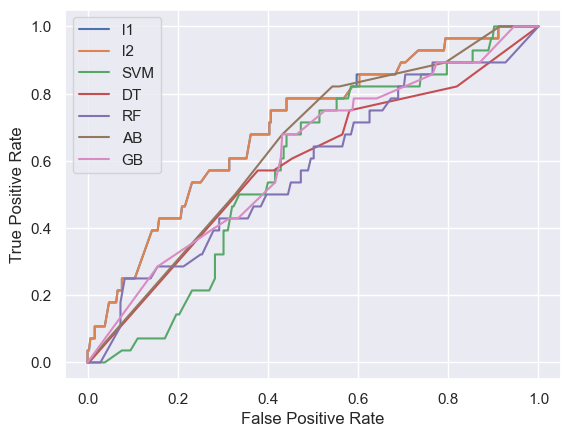

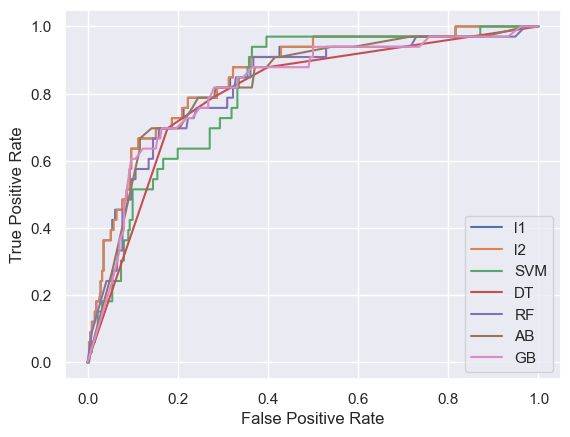

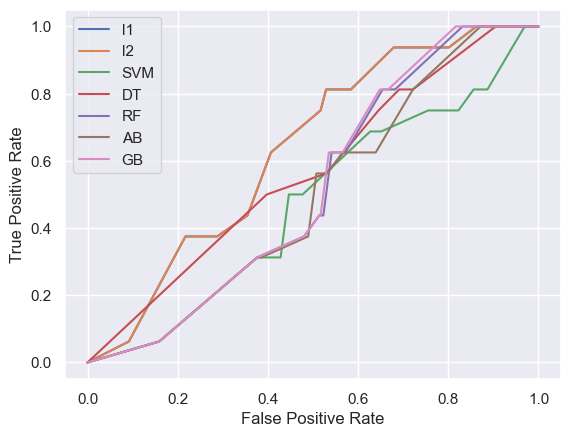

In [41]:
from sklearn import  metrics

for p in predictor:
    f, axs = plt.subplots(1, 1)
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + v + "_" + p +".pickle")
        metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax=axs) 
        #if v in best_result[best_result["outcome"] == p]["model"].values:
        #    metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k)
    axs.legend(list(model_dict.keys()))
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    plt.savefig("paper_figure/auc_curves_" + p + ".png",bbox_inches="tight")

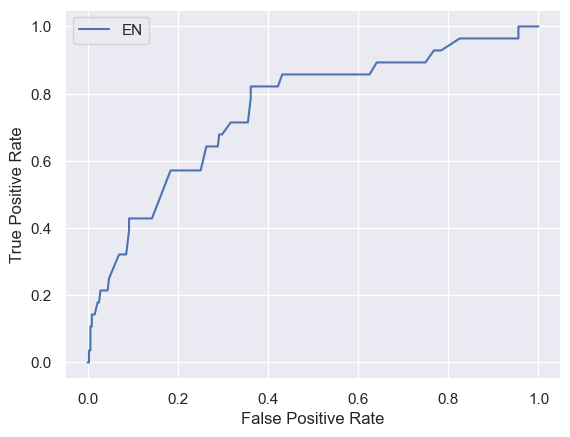

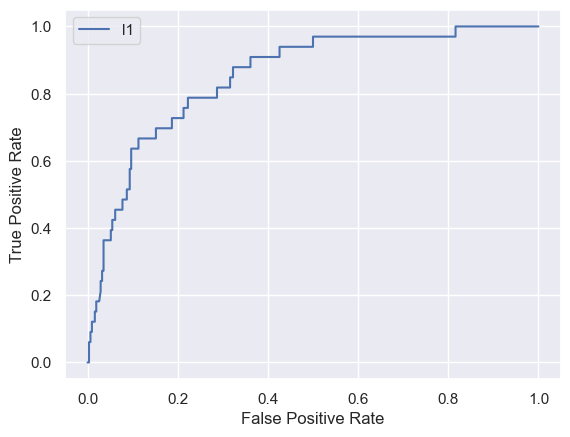

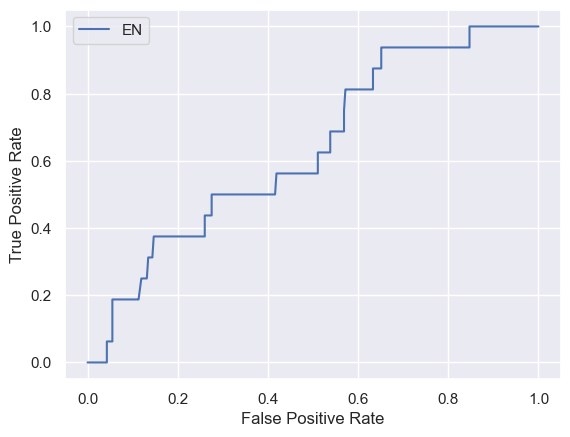

In [42]:


for p in predictor:
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    
    model_name = chosen_model[p][0]
    test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    f, axs = plt.subplots(1, 1)
    metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax= axs)
    axs.legend([chosen_model[p][1]])
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    plt.savefig("paper_figure/auc_curves_" + chosen_model[p][1] + "_"+p+ ".png",bbox_inches="tight")

In [37]:
for p in predictor:
    
    y_test = df_dummy[p]
    X_test = df_dummy.drop(predictor, axis=1)
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        if v in best_result[best_result["outcome"] == p]["model"].values:
            print(X_test.columns[test_pipe.named_steps["feature_selection"].get_support()])

Index(['respiratory_rate', 'spo2', 'lymphocytes', 'total_wcc', 'platelets',
       'ldh', 'sex_2', 'healthcare_worker_2.0', 'smoker_2.0', 'copd_2.0',
       'dialysis_3.0', 'chest_xray_2', 'chest_xray_3', 'vaccinated_1',
       'coronary_med_history_col_True'],
      dtype='object')
Index(['age', 'respiratory_rate', 'crp', 'total_wcc', 'platelets', 'sex_2',
       'healthcare_worker_2.0', 'hypertension_2.0', 'smoker_2.0', 'asthma_2.0',
       'chest_xray_3', 'vaccinated_1', 'pacemaker_1', 'troponin_uln_2.0',
       'coronary_med_history_col_True'],
      dtype='object')
Index(['ldh', 'creatinine', 'alt', 'sex_2', 'healthcare_worker_2.0',
       'hypertension_2.0', 'smoker_2.0', 'copd_2.0', 'asthma_2.0', 'ckd_2.0',
       'dialysis_3.0', 'chest_xray_3', 'pacemaker_1', 'troponin_uln_2.0',
       'coronary_med_history_col_True'],
      dtype='object')


# Probability Calibration

In [54]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
import os
dir = 'C:\\Users\\Harrison Nguyen\\Documents\\CardiacCovidModel\\covid_cardiac\\model\\'

No calibration: 0.125
0.8520527859237538
With isotonic calibration: 0.072
0.8612903225806452
With sigmoid calibration: 0.073
0.8619745845552297
No calibration: 0.203
0.7524943310657597
With isotonic calibration: 0.072
0.7244897959183674
With sigmoid calibration: 0.070
0.7400226757369615
No calibration: 0.219
0.6362767584097859
With isotonic calibration: 0.045
0.5254204892966361
With sigmoid calibration: 0.045
0.42909021406727826


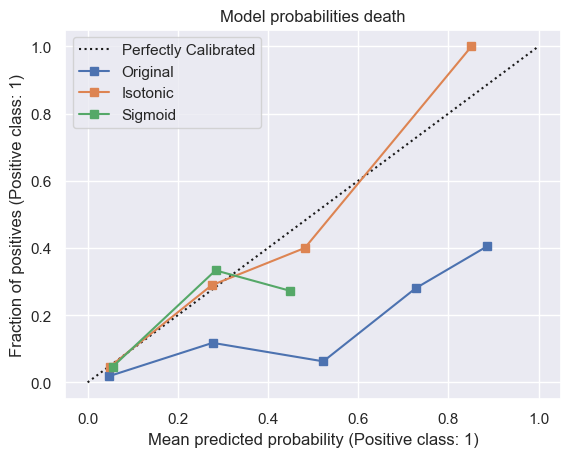

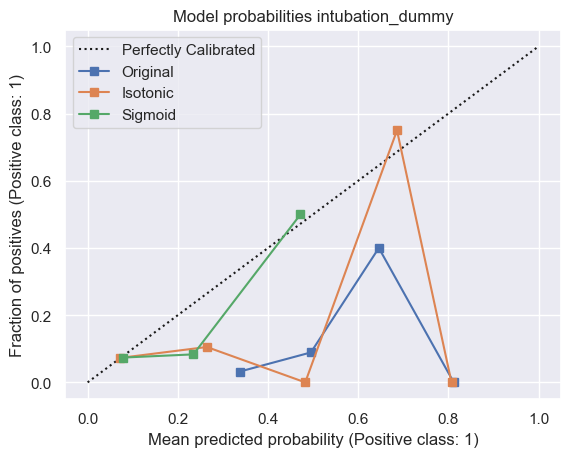

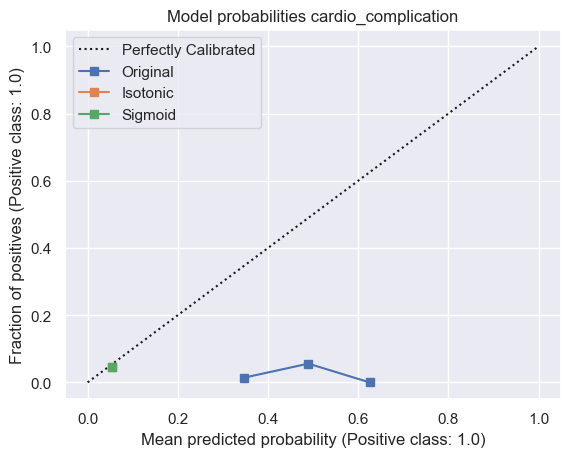

In [44]:
for k,v in chosen_model.items():
    p = k
    pipe = joblib.load(os.path.join(dir,"{}_{}.pickle".format(v[0],k)))
        
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    clf_isotonic = CalibratedClassifierCV(pipe, cv=5, method="isotonic")
    clf_isotonic.fit(X_train, y_train)
    
    joblib.dump(clf_isotonic,"model/" + v[0] + "_" + k + "_isotonic_calibration" +".pickle")

    clf_sigmoid = CalibratedClassifierCV(pipe, cv=5, method="sigmoid")
    clf_sigmoid.fit(X_train, y_train)
    joblib.dump(clf_sigmoid,"model/" + v[0] + "_" + k + "_sigmoid_calibration" +".pickle")


    y_test = test[p]
    X_test = test.drop(predictor, axis=1)

    prob_pos_clf = pipe.predict_proba(X_test)[:, 1]
    clf_score = brier_score_loss(y_test, prob_pos_clf)
    print("No calibration: %1.3f" % clf_score)
    yhat_proba = pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))

    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)
    yhat_proba = clf_isotonic.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))

    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
    yhat_proba = clf_sigmoid.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))
    
    f,ax = plt.subplots()
    CalibrationDisplay.from_estimator(pipe, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_isotonic, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_sigmoid, X_test, y_test,ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Perfectly Calibrated","Original","Isotonic","Sigmoid"])
    ax.set_title("Model probabilities " + p)
    
    plt.savefig("paper_figure/calibration_plot_" + p +".png",bbox_inches="tight")

### evaluate calibrated models 

In [58]:
# https://stackoverflow.com/questions/54318912/does-calibration-improve-roc-score
test_df_calibrated = pd.DataFrame.from_dict(
    {'model': [],
     'calibration':[],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})

for k,v in chosen_model.items():
    p = k
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    for c in ["isotonic","sigmoid","none"]:

        model_name = v[0]
        if c == "none":
            test_pipe = joblib.load("model/{}_{}.pickle".format(model_name,p))
        else:
            test_pipe = joblib.load("model/{}_{}_{}_calibration.pickle".format(model_name,p,c))
        test_result_df = evaluate_model(test_pipe,X_test,y_test)
        #print(test_pipe.predict_proba(X_test)[:,1])
        test_result_df["outcome"] = p
        test_result_df["model"] = model_name
        test_result_df["calibration"] = c
        test_result_df["brier_score"] = brier_score_loss(y_test, test_pipe.predict_proba(X_test)[:,1])

        test_df_calibrated = pd.concat([test_df_calibrated,test_result_df],ignore_index=True)
test_df_calibrated.to_csv("result/final_outcome_calibrated.csv")

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
test_df_calibrated 

model calibration  accuracy  precision  \
0          l1_feature_selection5_oversample    isotonic  0.895044   0.285714   
1          l1_feature_selection5_oversample     sigmoid  0.906706   1.000000   
2          l1_feature_selection5_oversample        none  0.830904   0.323944   
3  elasticnet_feature_selection5_oversample    isotonic  0.918367   0.500000   
4  elasticnet_feature_selection5_oversample     sigmoid  0.912536   0.000000   
5  elasticnet_feature_selection5_oversample        none  0.699708   0.168142   
6  elasticnet_feature_selection5_oversample    isotonic  0.953353   0.000000   
7  elasticnet_feature_selection5_oversample     sigmoid  0.953353   0.000000   
8  elasticnet_feature_selection5_oversample        none  0.737609   0.069767   

     recall  f1_score       auc              outcome  brier_score  
0  0.060606       NaN  0.861290                death     0.072024  
1  0.030303       NaN  0.861975                death     0.072541  
2  0.696970       NaN  0.852053                death     0.124651  
3  0.107143       NaN  0.724490     intubation_dummy     0.072434  
4  0.000000       NaN  0.740023     intubation_dummy     0.069922  
5  0.678571       NaN  0.752494     intubation_dummy     0.203110  
6  0.000000       NaN  0.525420  cardio_complication     0.044882  
7  0.000000       NaN  0.429090  cardio_complication     0.044632  
8  0.375000       NaN  0.636277  cardio_complication     0.219405

## plotting auc vs n features

In [29]:
max_features = len(df_dummy.columns)

In [30]:
final_result_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[],
    'oversample':[],
    'n_feature':[]})

In [31]:
model_dict = {
    'l1':'l1',
    'l2':'l2',
    'EN':'elasticnet',
    'SVM':'svm',
    'DT':'decision',
    'RF':'rf',
    'AB':'adaboost',
    'GB': 'gb',
    #'logistic':'logistic'
}

In [32]:
n_features = [5,10,15,20,'all']
for k,v in model_dict.items():
    for p in predictor:
        for n in n_features:
            for use_oversample in [True]:
                if use_oversample:
                    model_name = v + '_feature_selection'+str(n)+'_oversample'
                else:
                    model_name = v + '_feature_selection'+str(n)
                y_test = test[p]
                X_test = test.drop(predictor, axis=1)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                test_result_df = evaluate_model(pipe,X_test,y_test)
                test_result_df["outcome"] = p
                test_result_df["model"] = k
                test_result_df["oversample"] = use_oversample
                if n == 'all':
                    n = max_features
                test_result_df["n_feature"] = n

                final_result_df = pd.concat([final_result_df,test_result_df],ignore_index=True)

In [33]:
final_result_df

model  accuracy  precision    recall  f1_score       auc  \
0      l1  0.685131   0.142857  0.571429  0.228571  0.700680   
1      l1  0.752187   0.164706  0.500000  0.247788  0.685204   
2      l1  0.752187   0.156627  0.464286  0.234234  0.704535   
3      l1  0.743440   0.142857  0.428571  0.214286  0.690476   
4      l1  0.755102   0.131579  0.357143  0.192308  0.692744   
..    ...       ...        ...       ...       ...       ...   
115    GB  0.609329   0.039062  0.312500  0.069444  0.518826   
116    GB  0.559767   0.046980  0.437500  0.084848  0.526758   
117    GB  0.708455   0.062500  0.375000  0.107143  0.587252   
118    GB  0.743440   0.071429  0.375000  0.120000  0.580466   
119    GB  0.720117   0.065217  0.375000  0.111111  0.650994   

                 outcome oversample  n_feature  
0       intubation_dummy        1.0        5.0  
1       intubation_dummy       True       10.0  
2       intubation_dummy       True       15.0  
3       intubation_dummy       True       20.0  
4       intubation_dummy       True       41.0  
..                   ...        ...        ...  
115  cardio_complication       True        5.0  
116  cardio_complication       True       10.0  
117  cardio_complication       True       15.0  
118  cardio_complication       True       20.0  
119  cardio_complication       True       41.0  

[120 rows x 9 columns]

In [45]:
final_result_df.to_csv("result/final_outcome_test.csv")

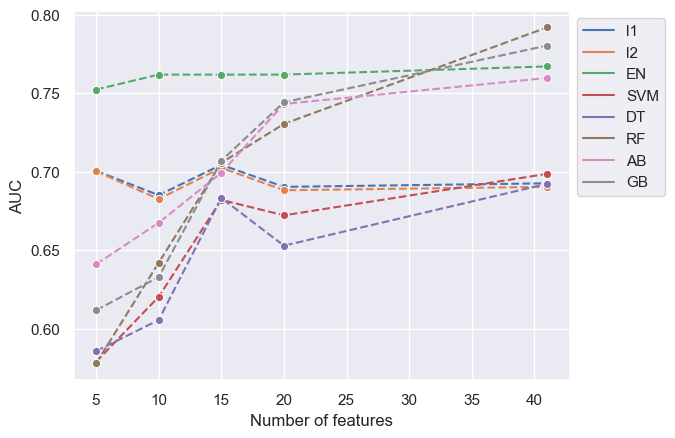

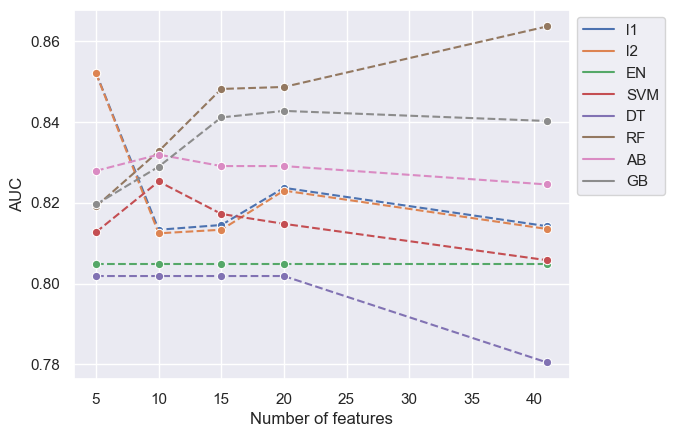

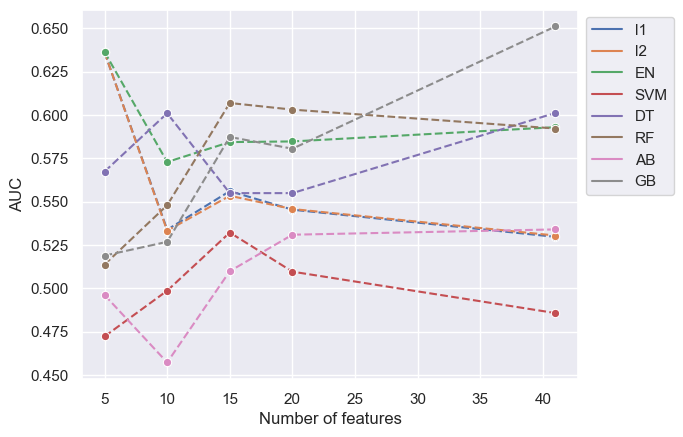

In [46]:
final_result_df = pd.read_csv("result/final_outcome_test.csv",index_col=0)
# generate AUC curves against n of features
for p in predictor:
    f,ax = plt.subplots()
    #for m in final_result_df["model"].unique():
    df_sub = final_result_df.query("outcome == @p")
    ax = sns.lineplot(df_sub,x = 'n_feature',y='auc',hue='model',ax=ax,marker='o',linestyle ='--')
    ax.set_xlabel('Number of features')
    ax.set_ylabel('AUC')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig("paper_figure/n_feature_plot_" + p +".png",bbox_inches="tight")

## tree importance

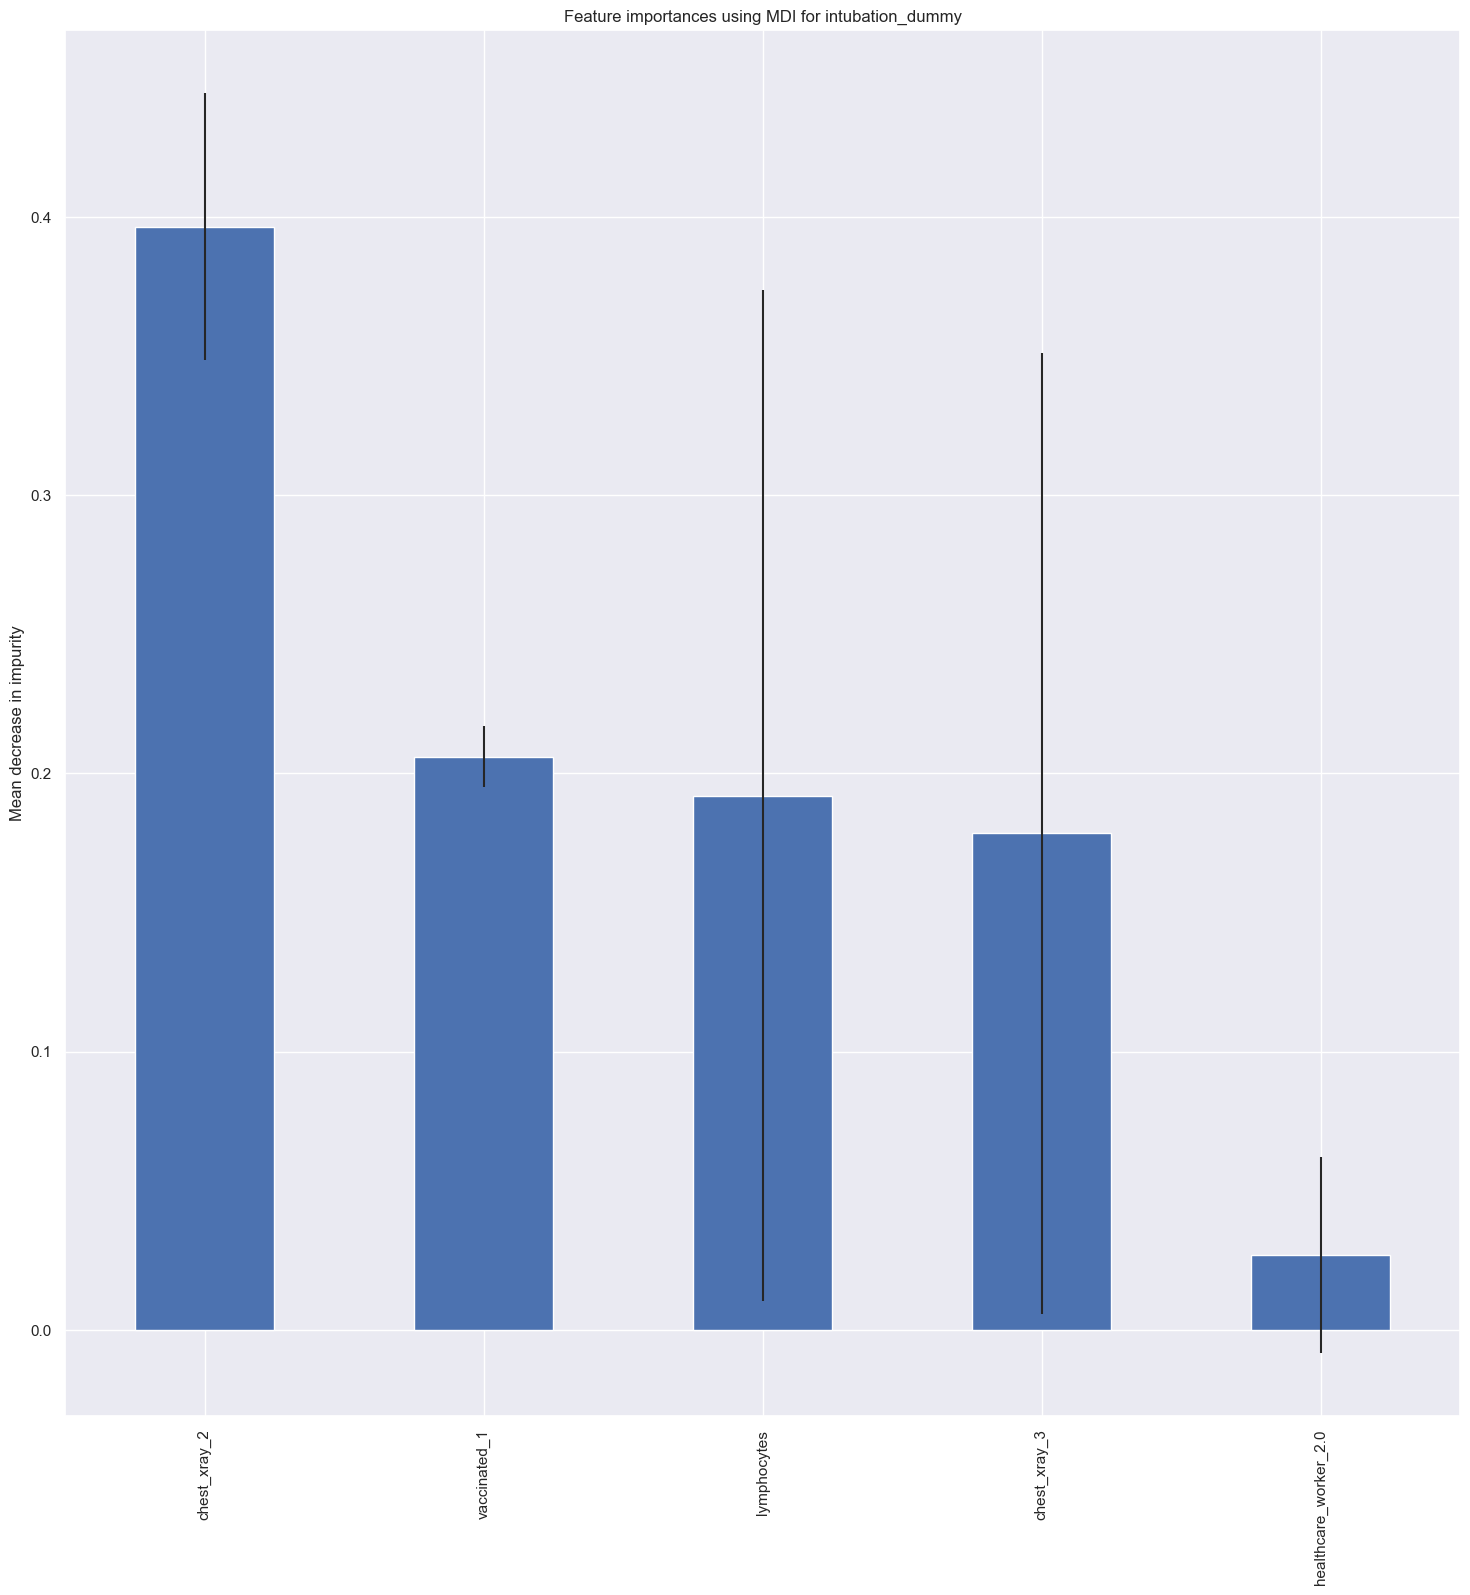

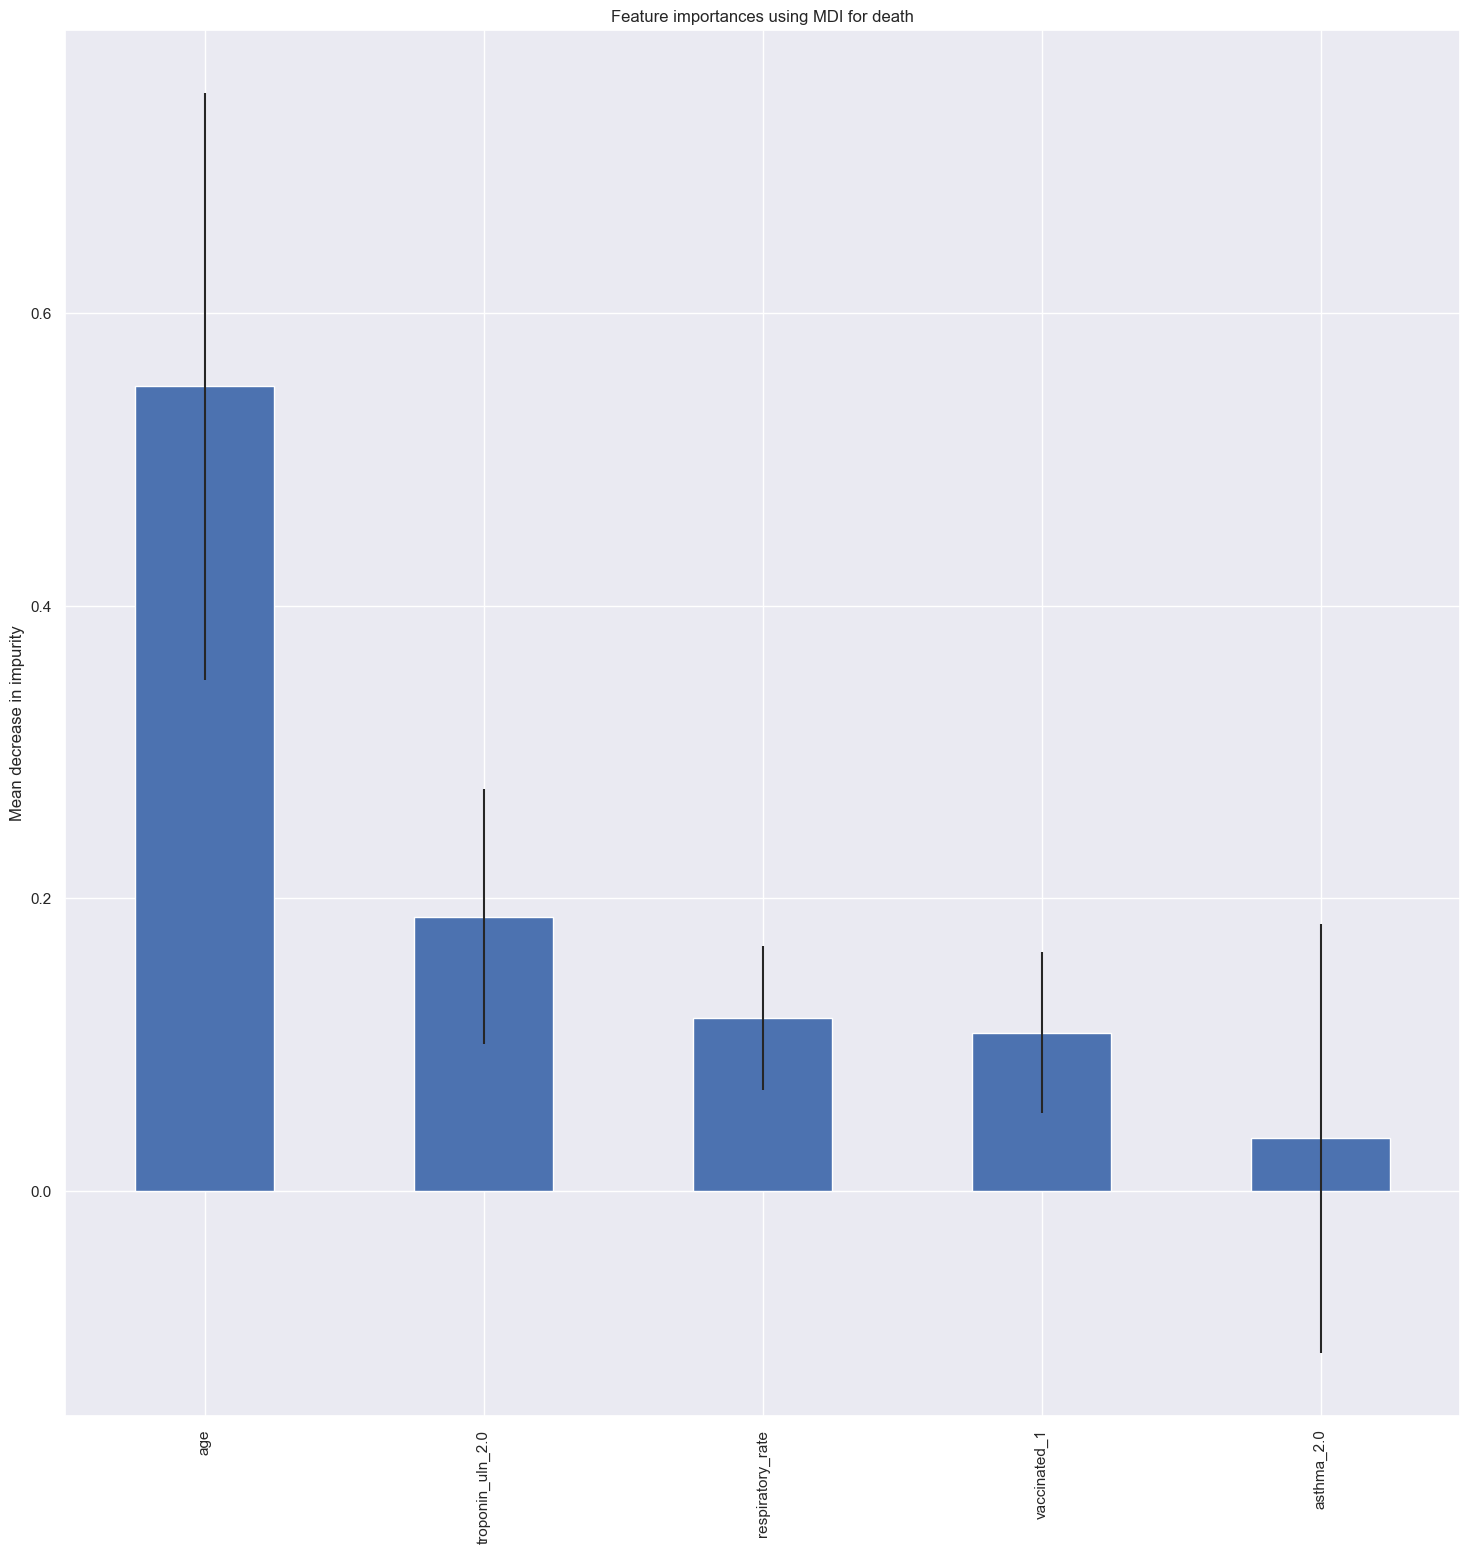

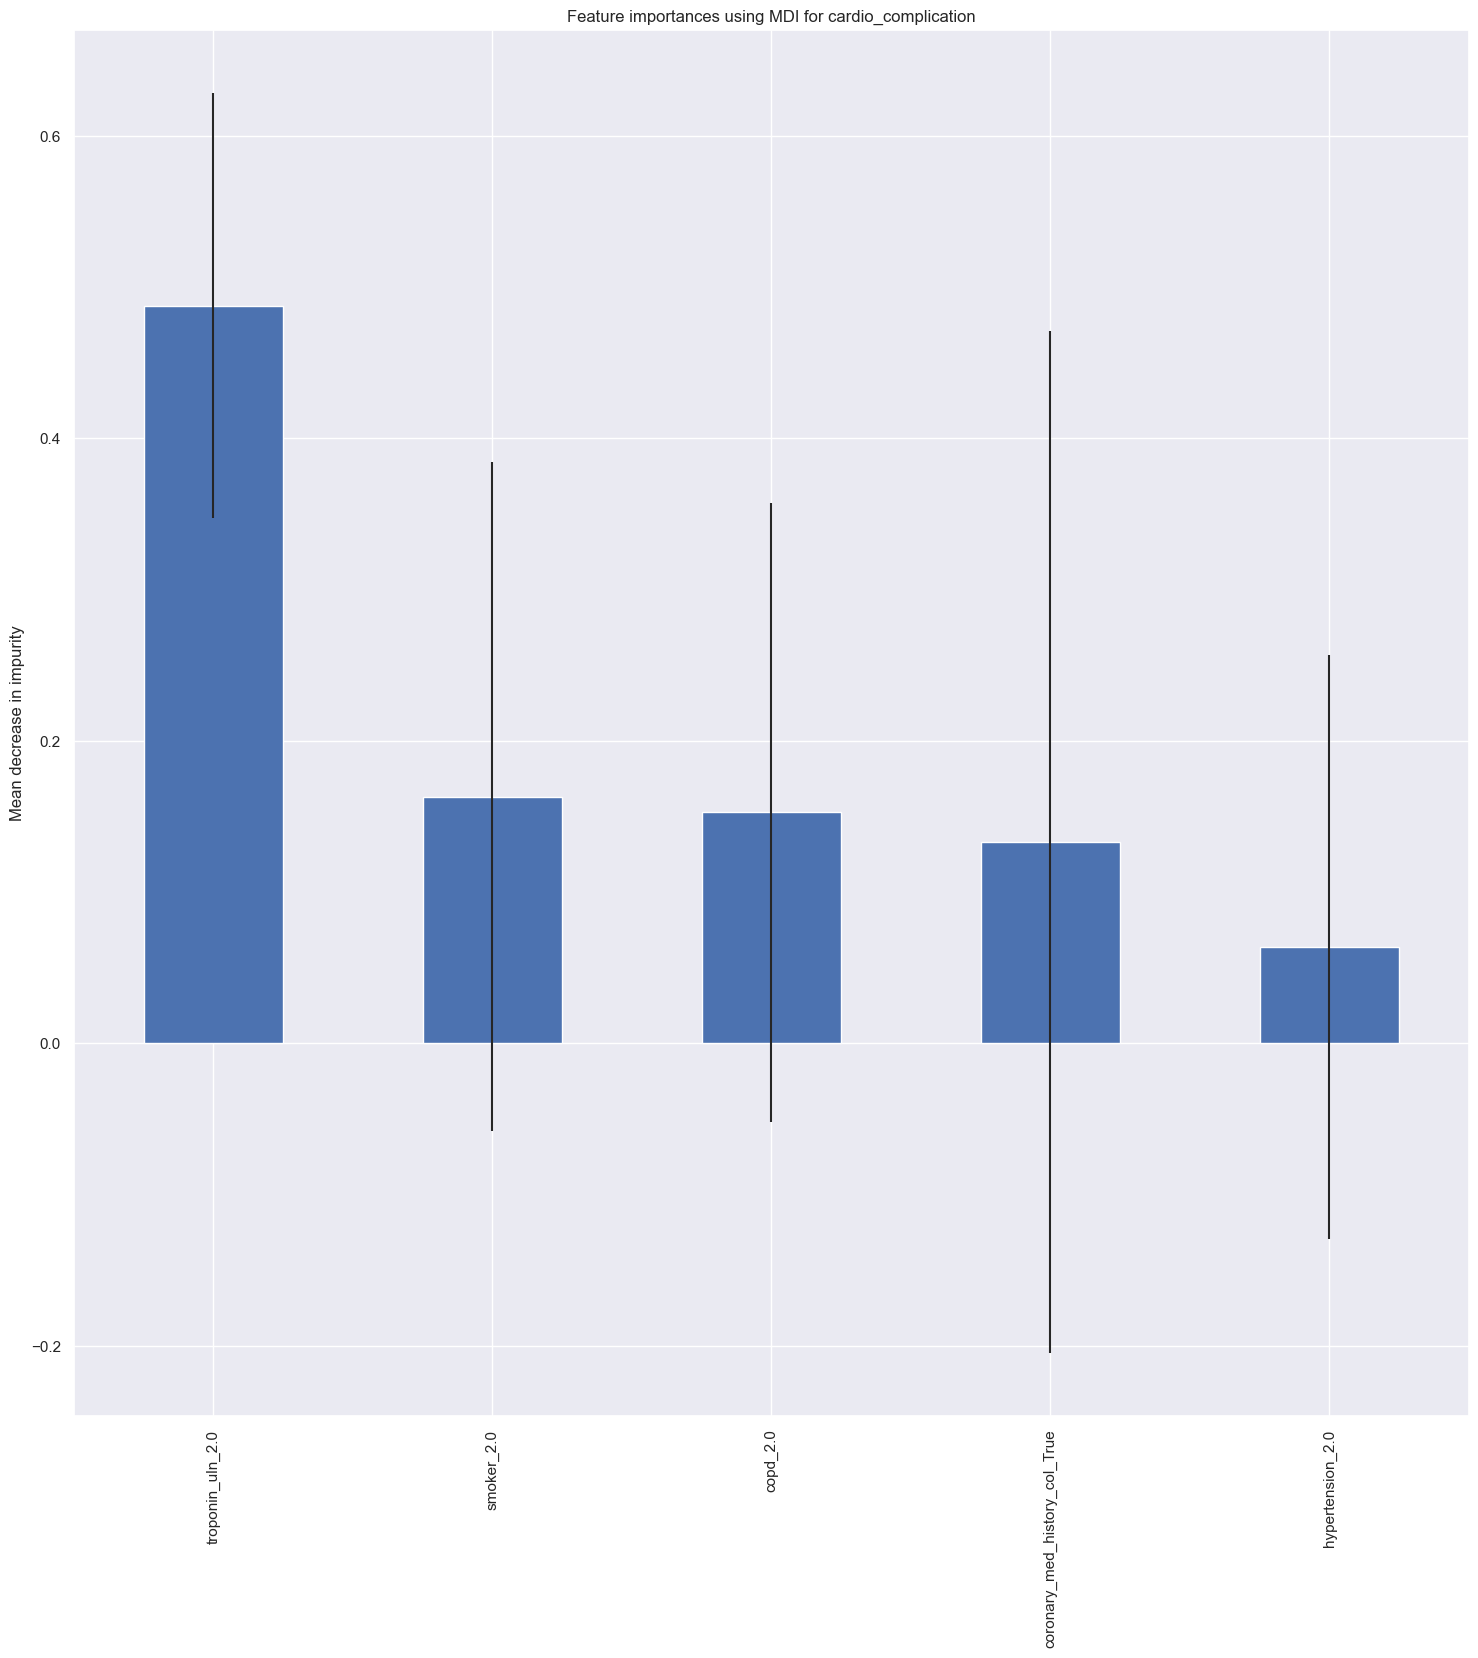

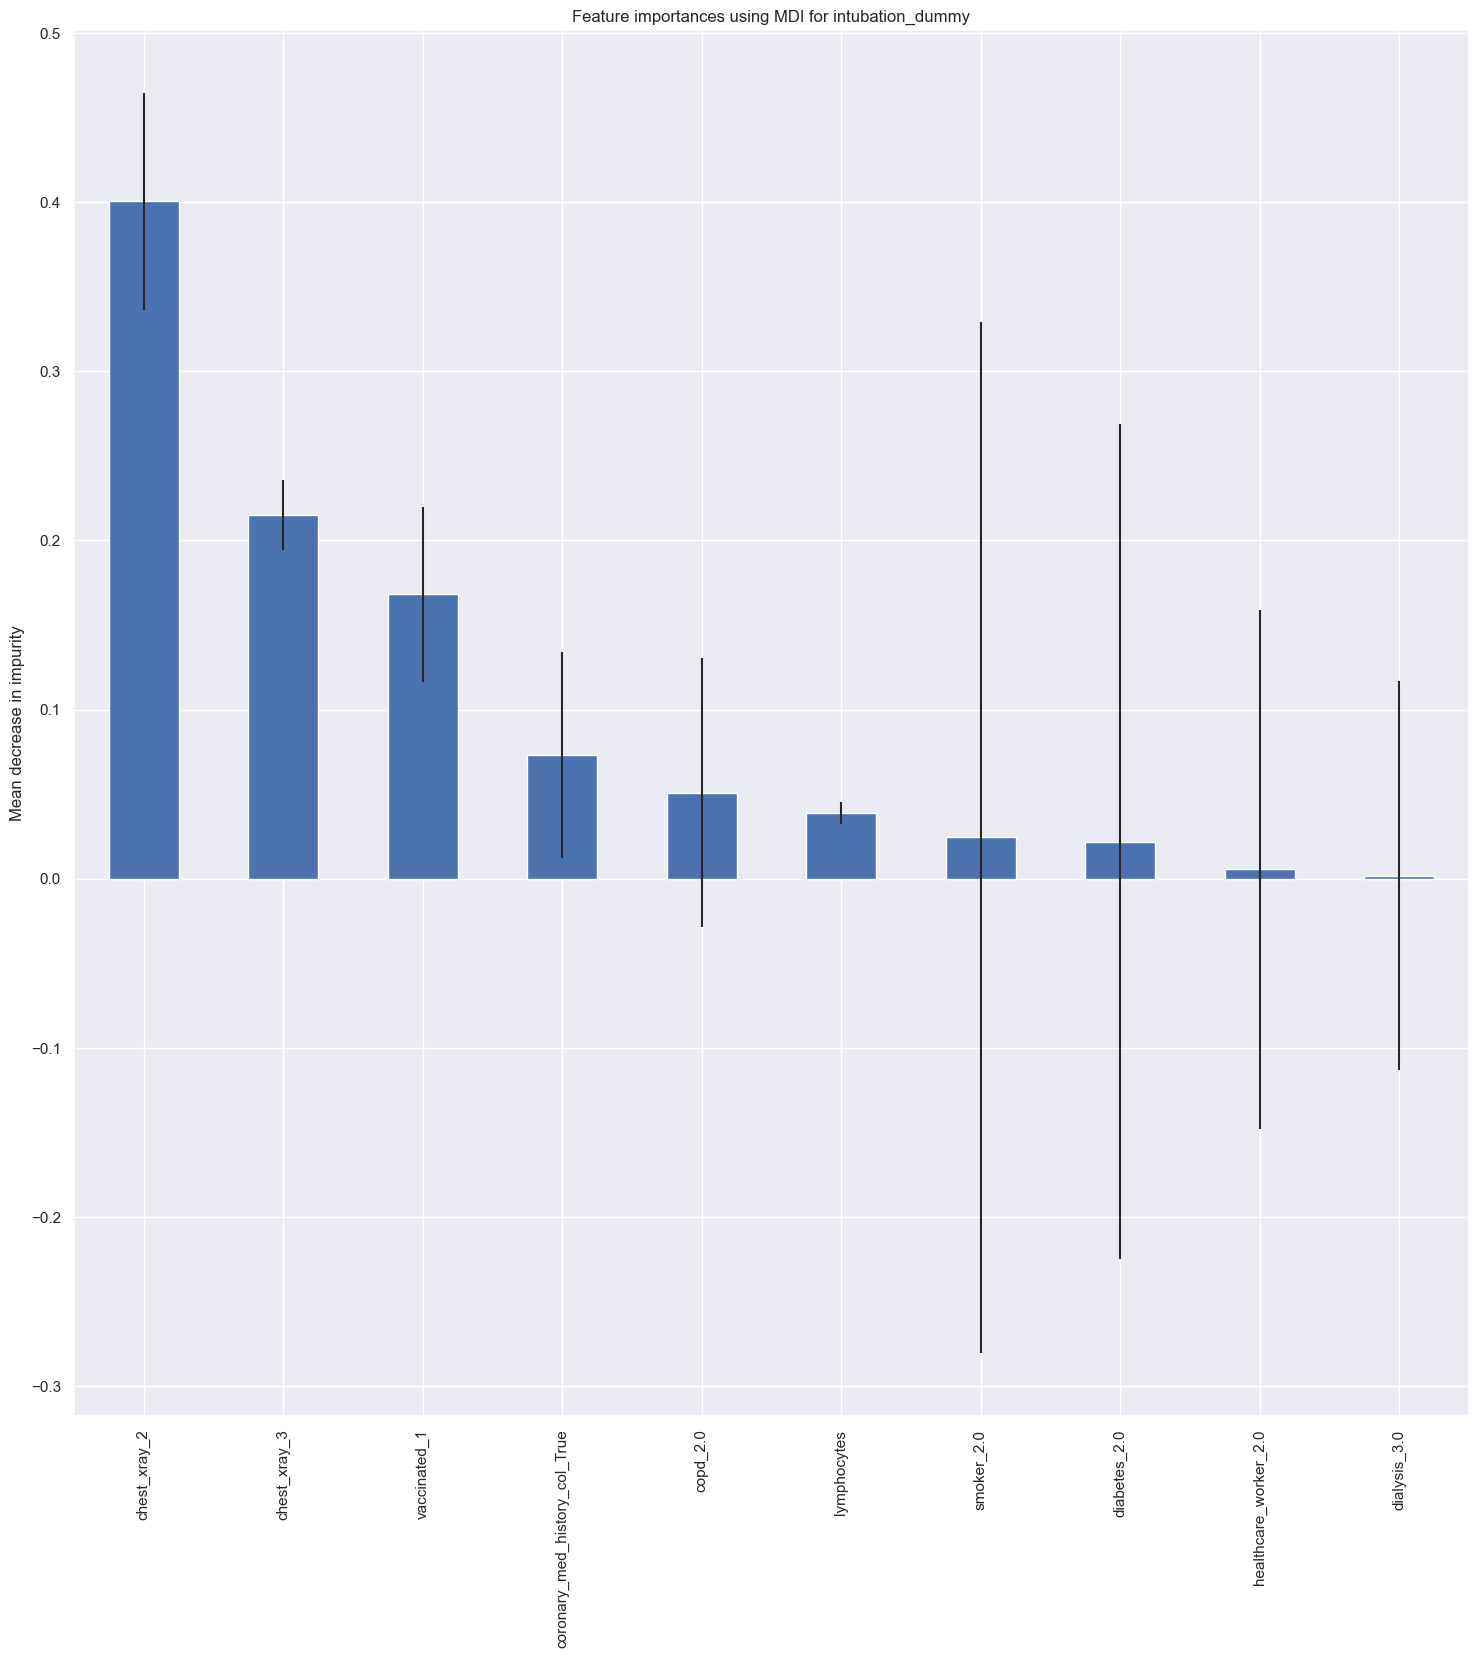

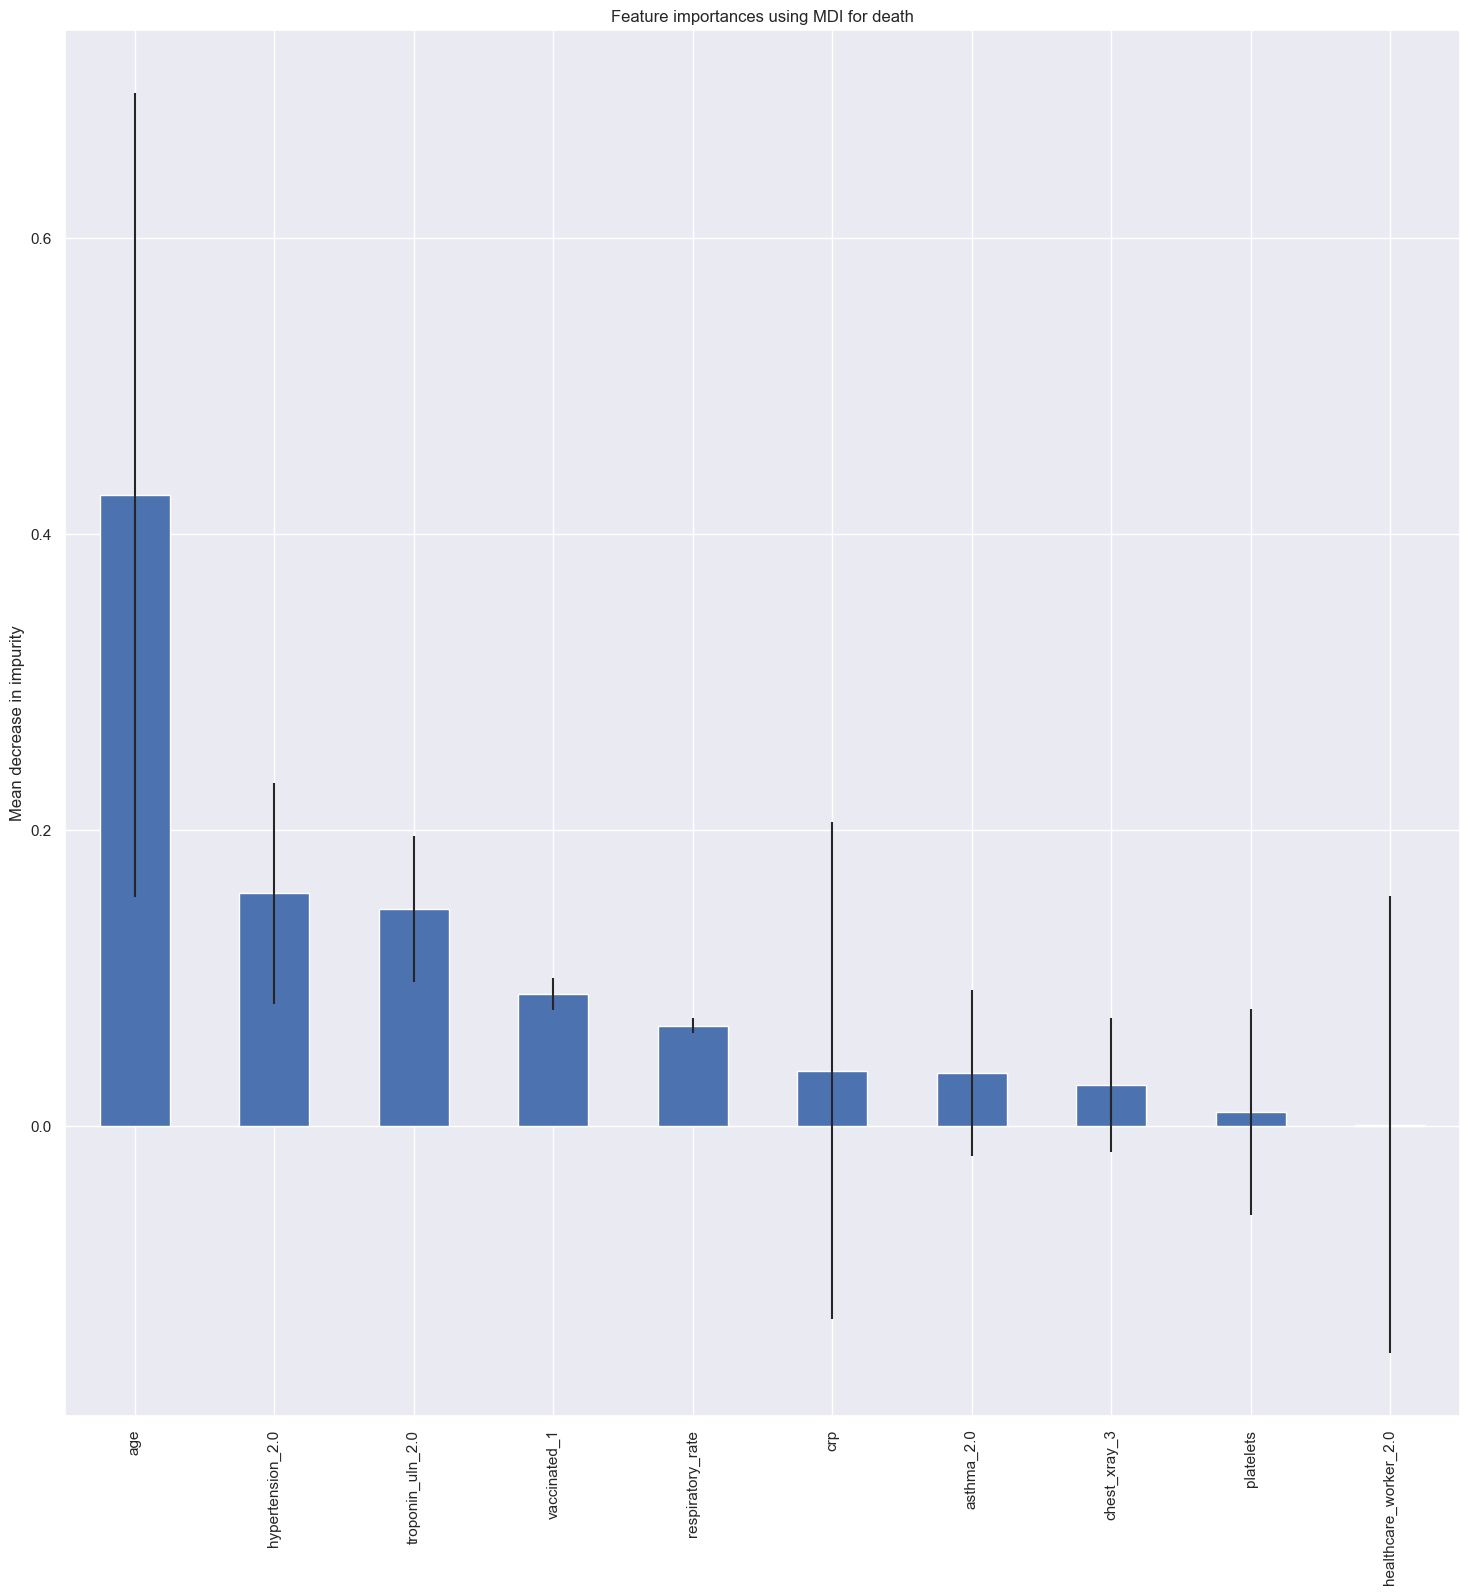

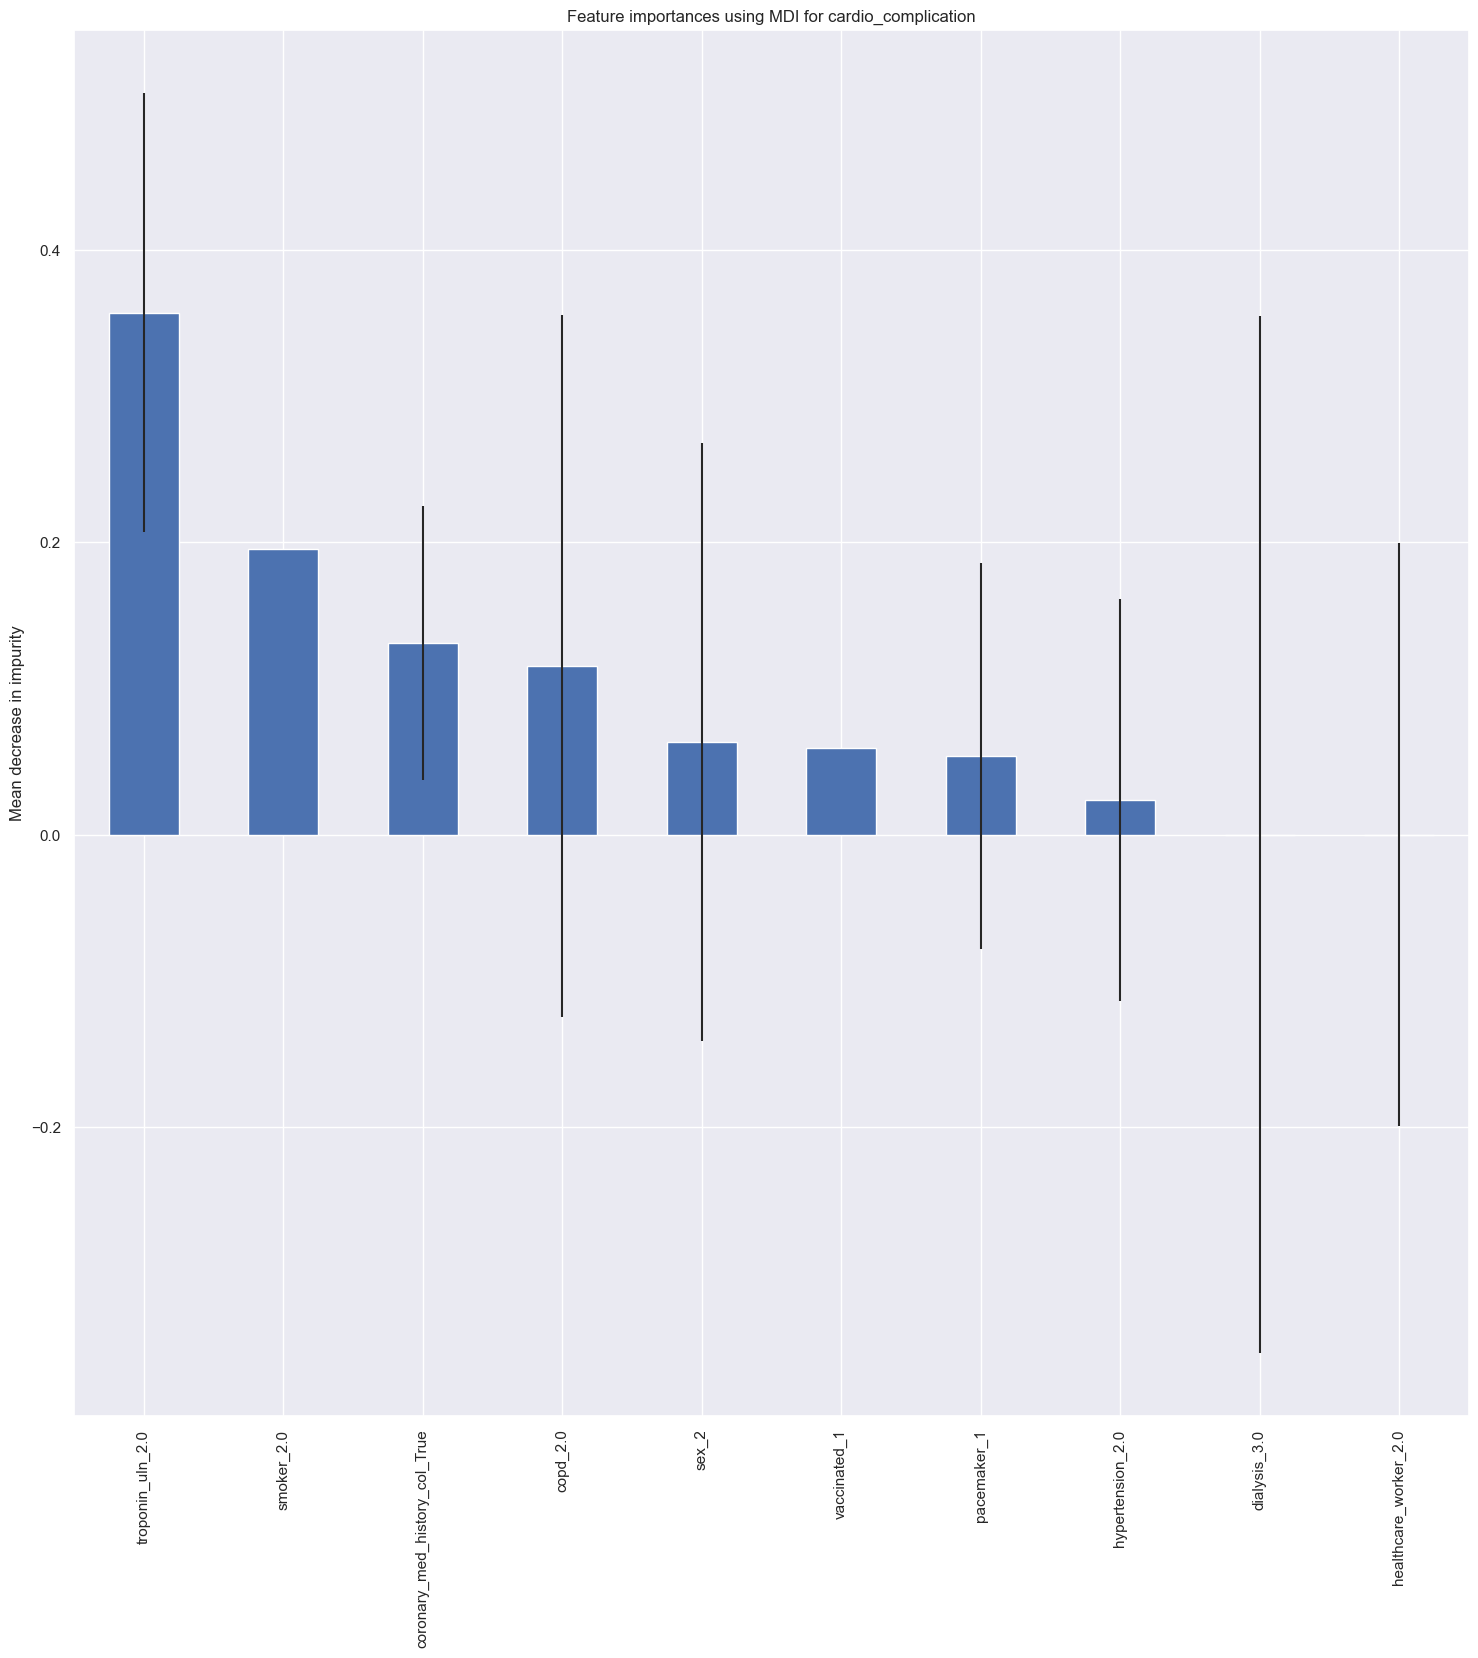

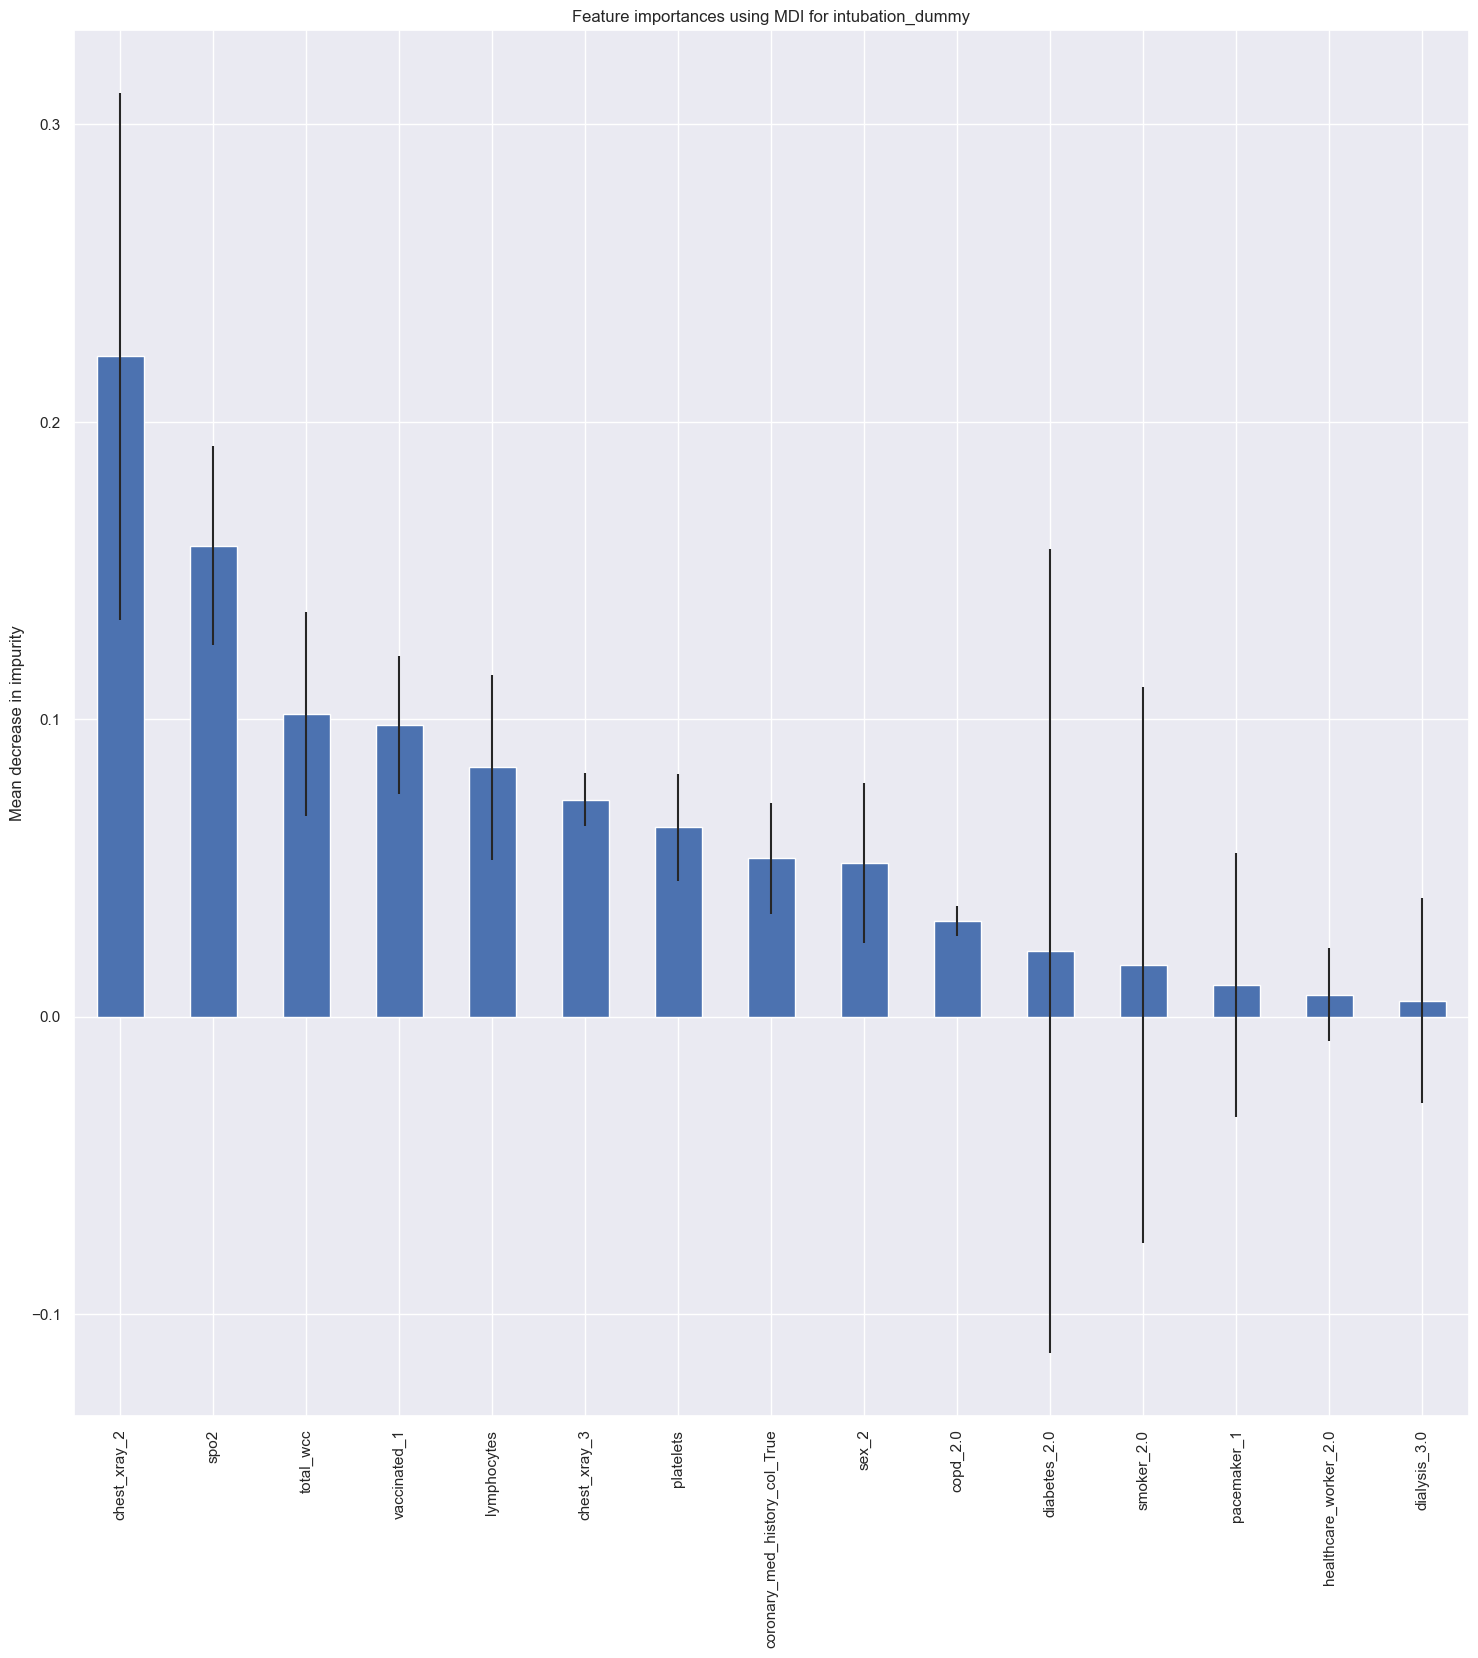

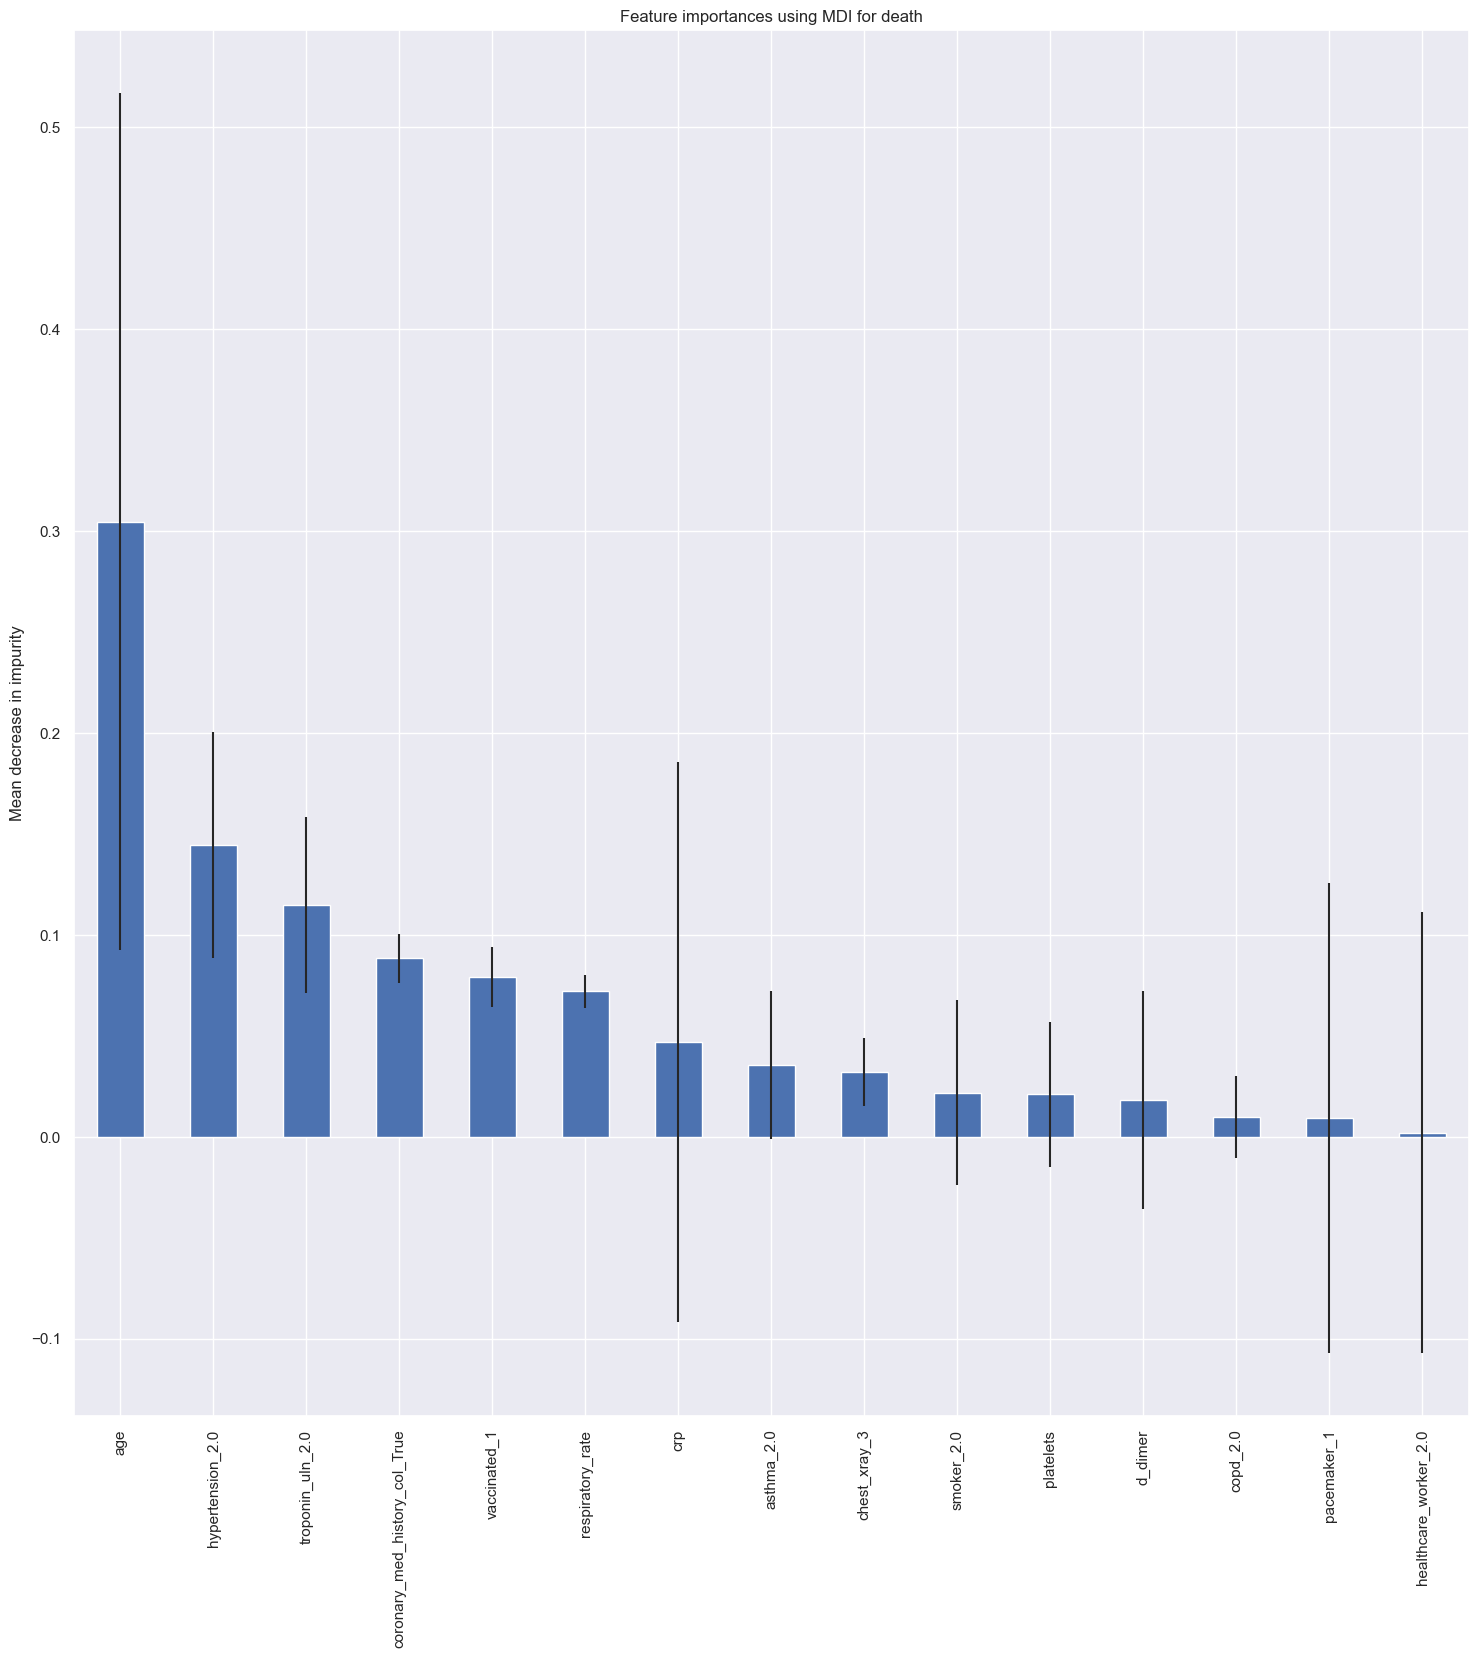

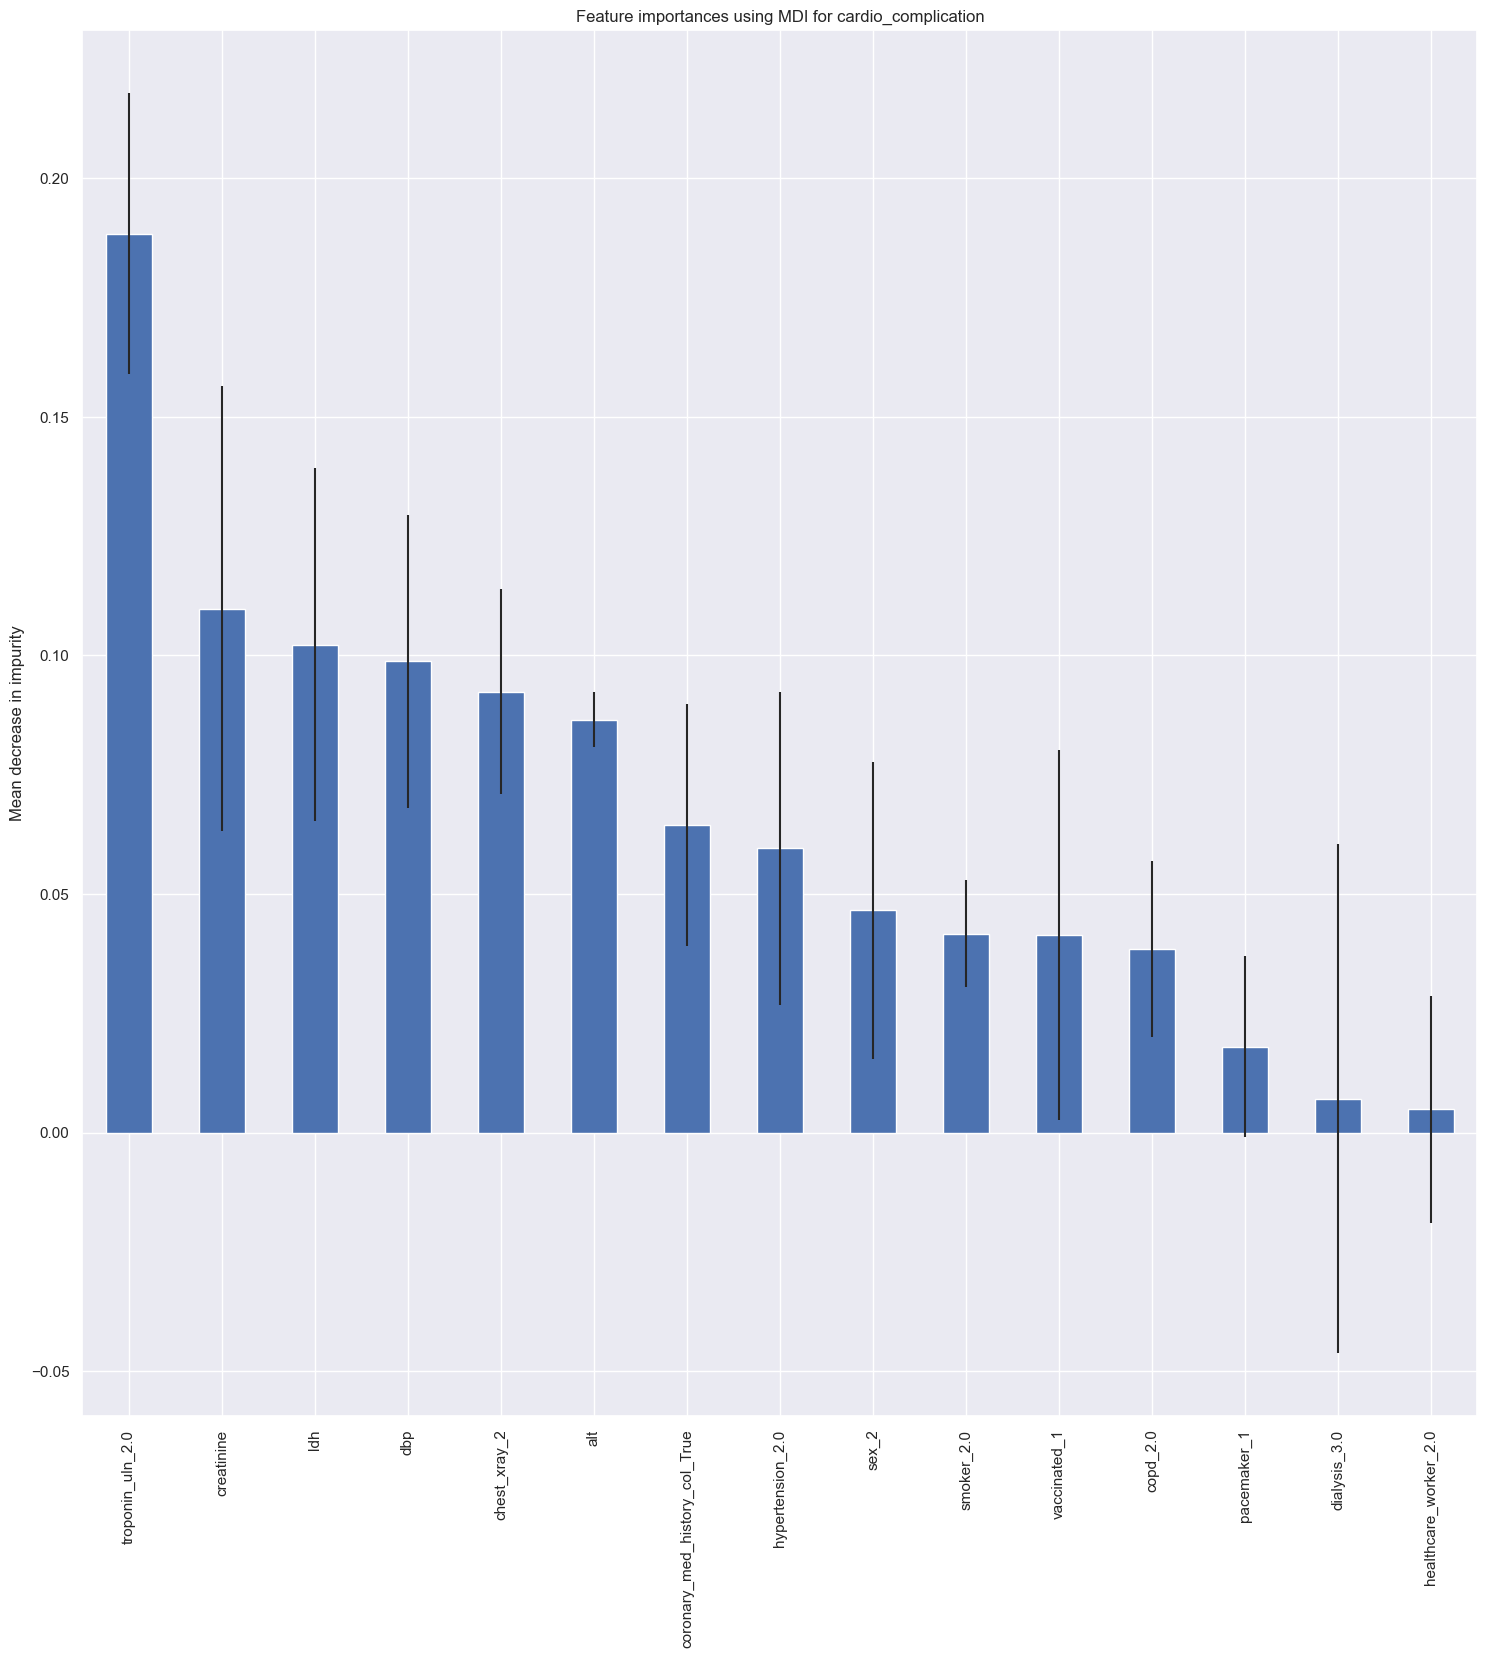

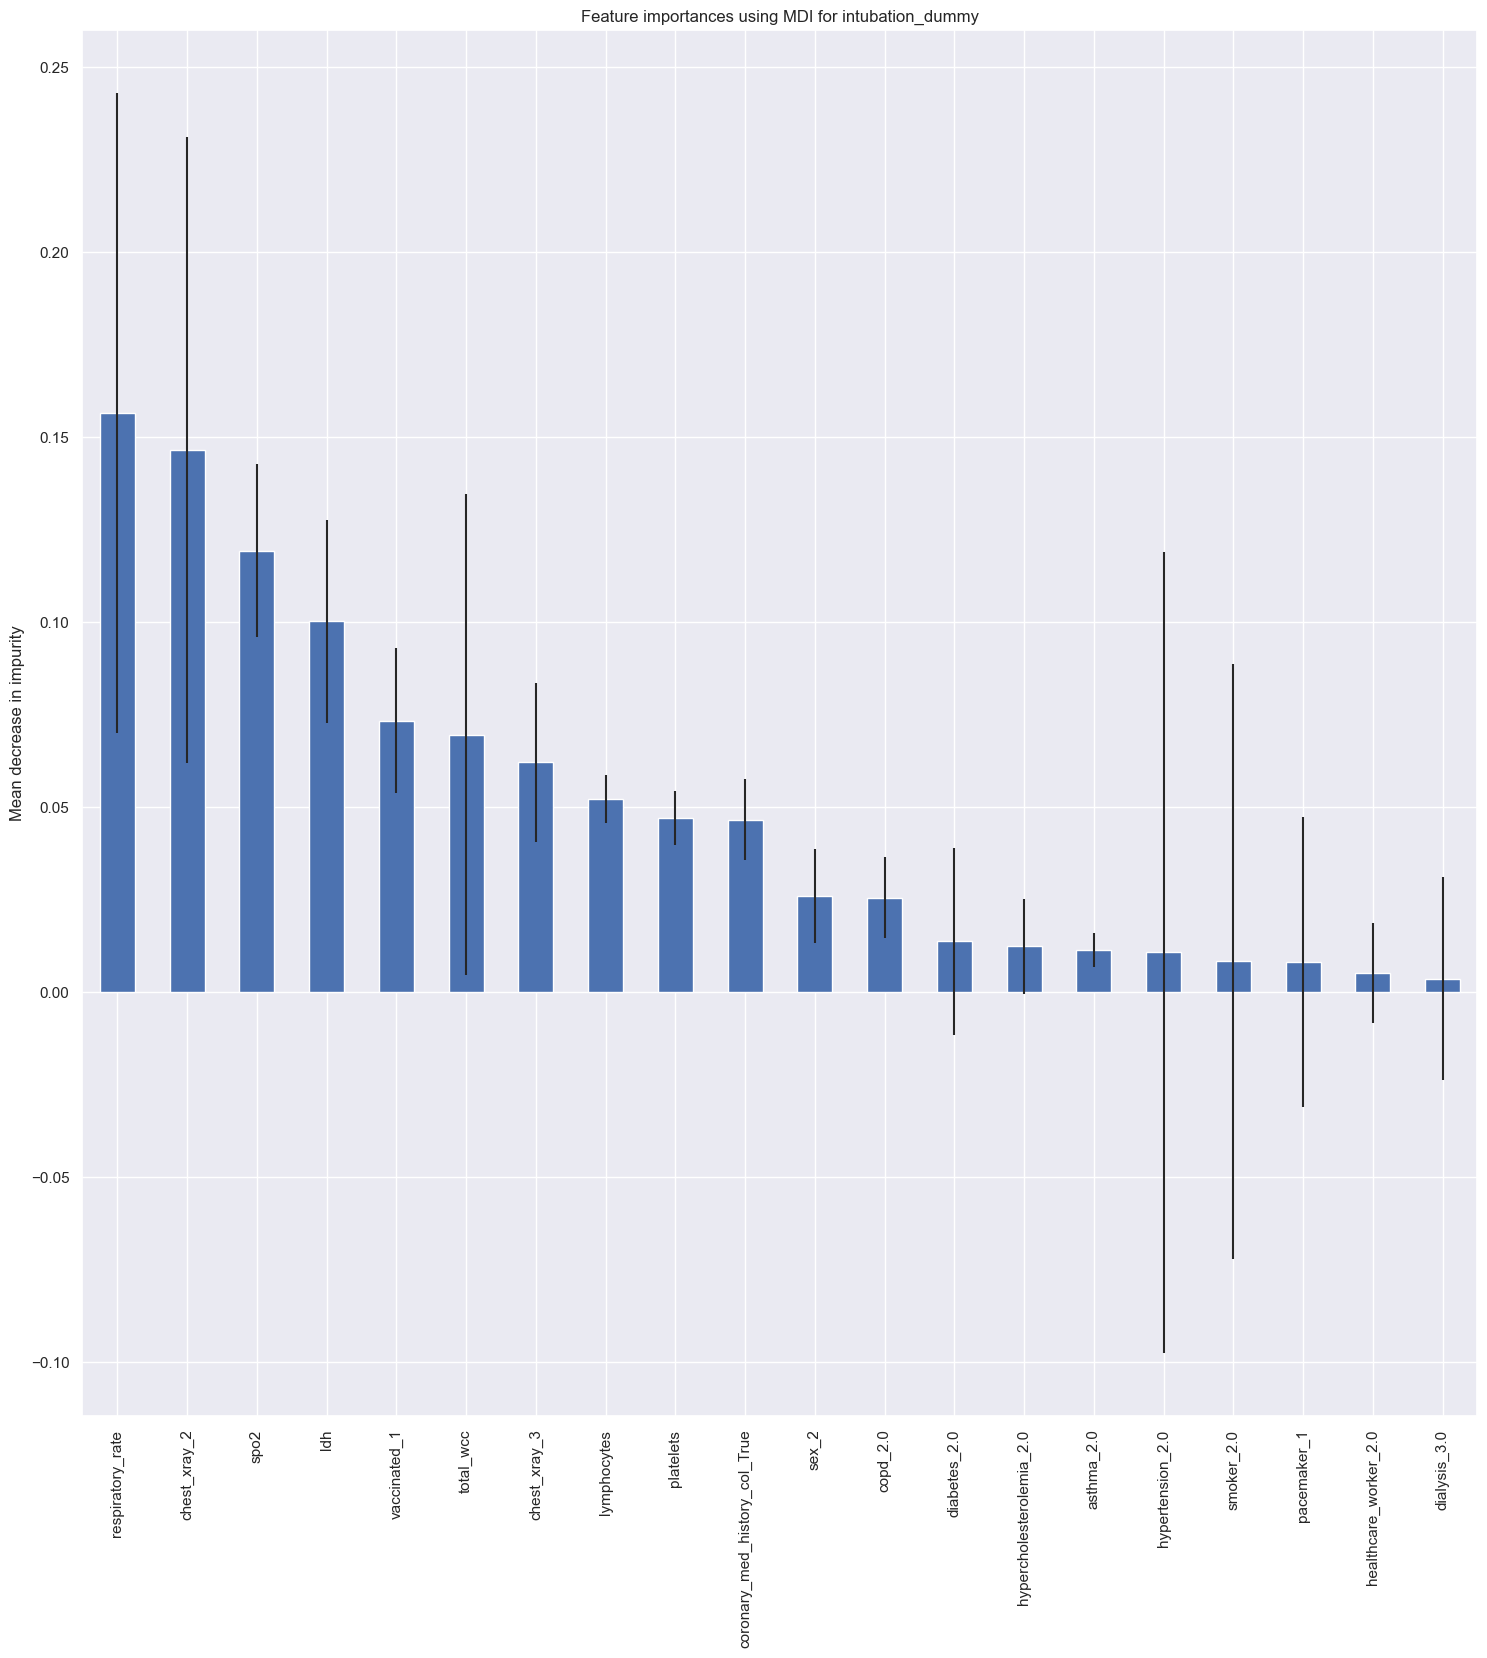

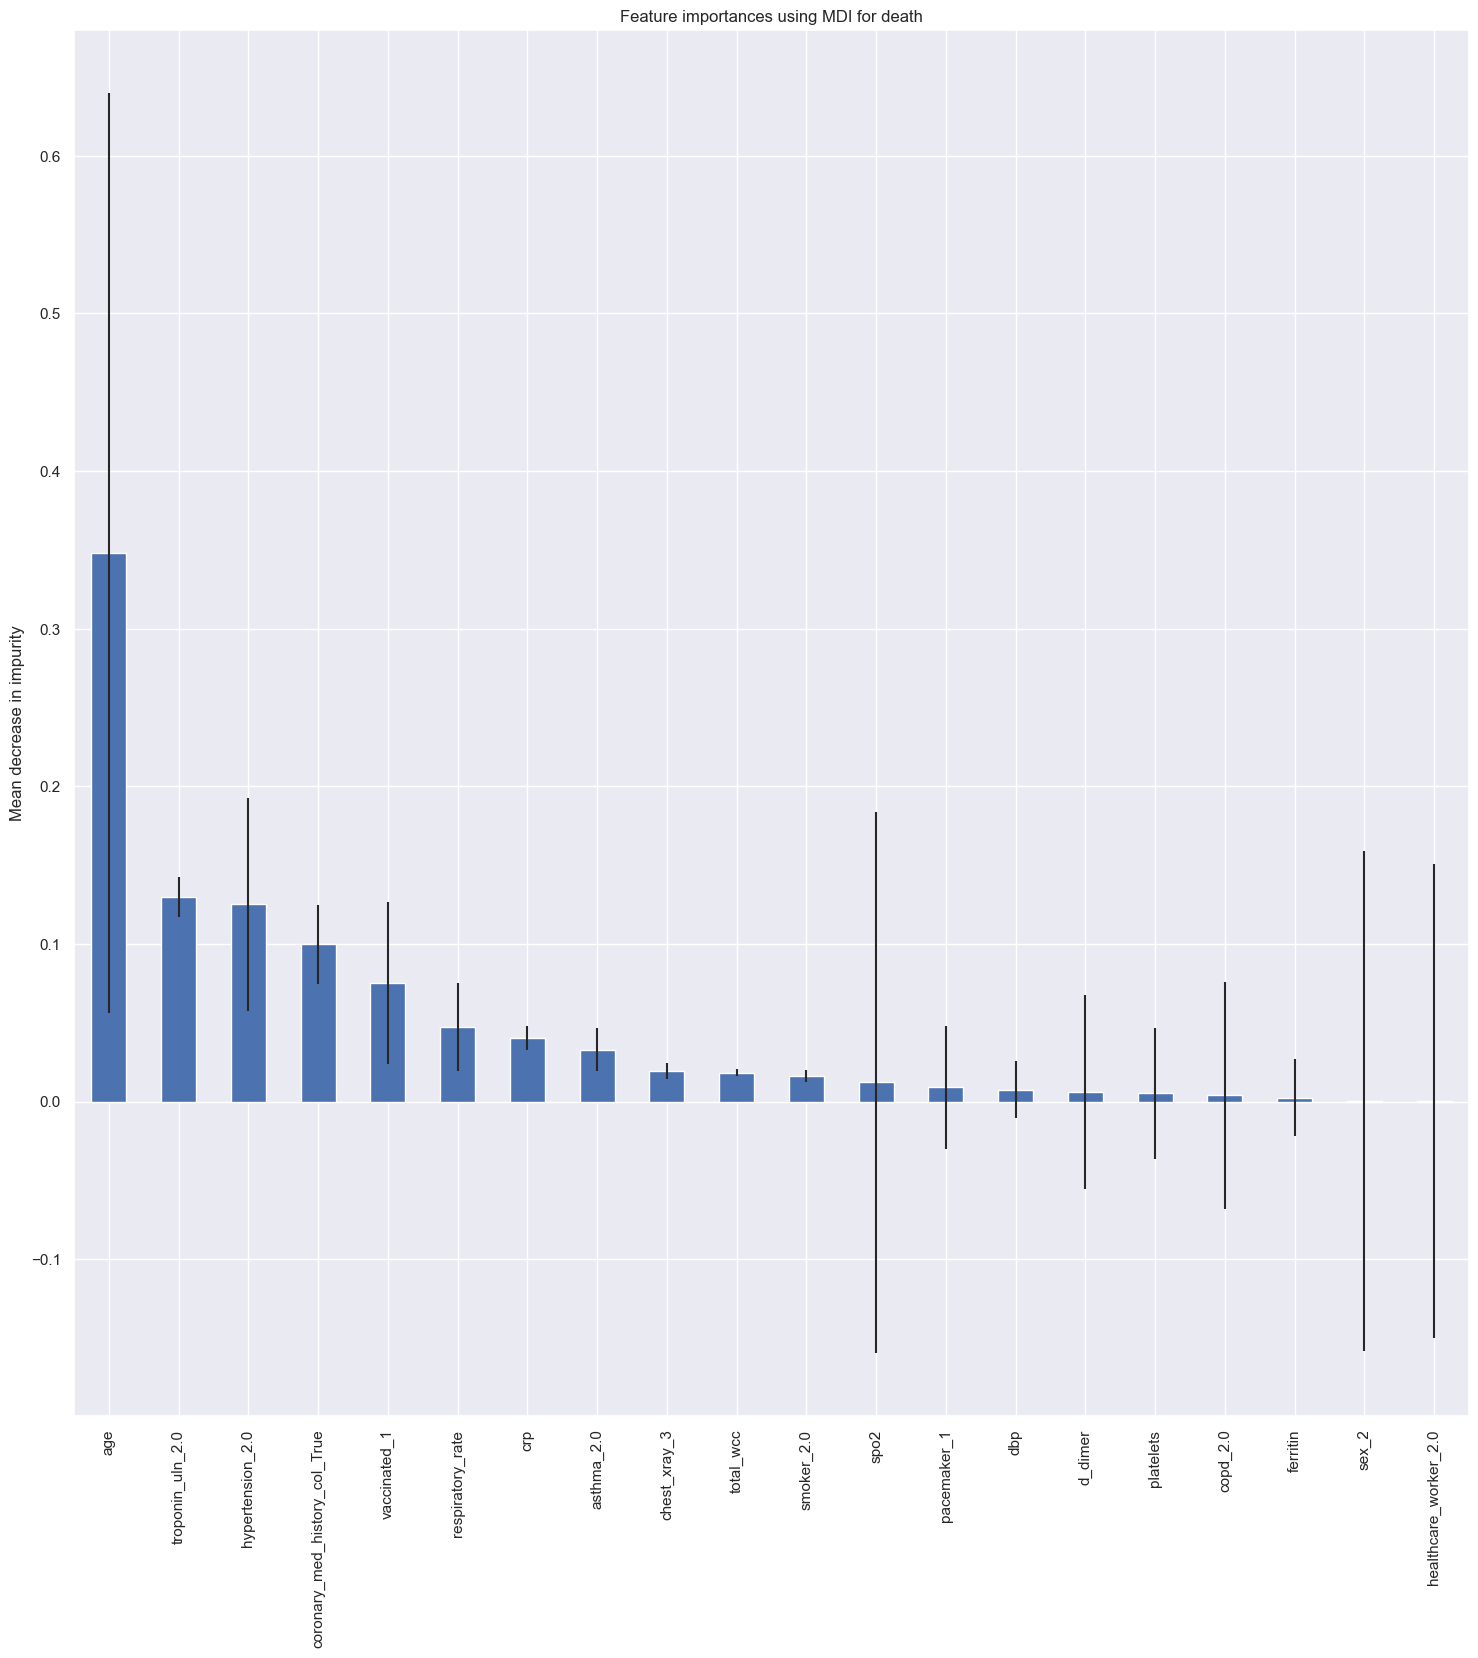

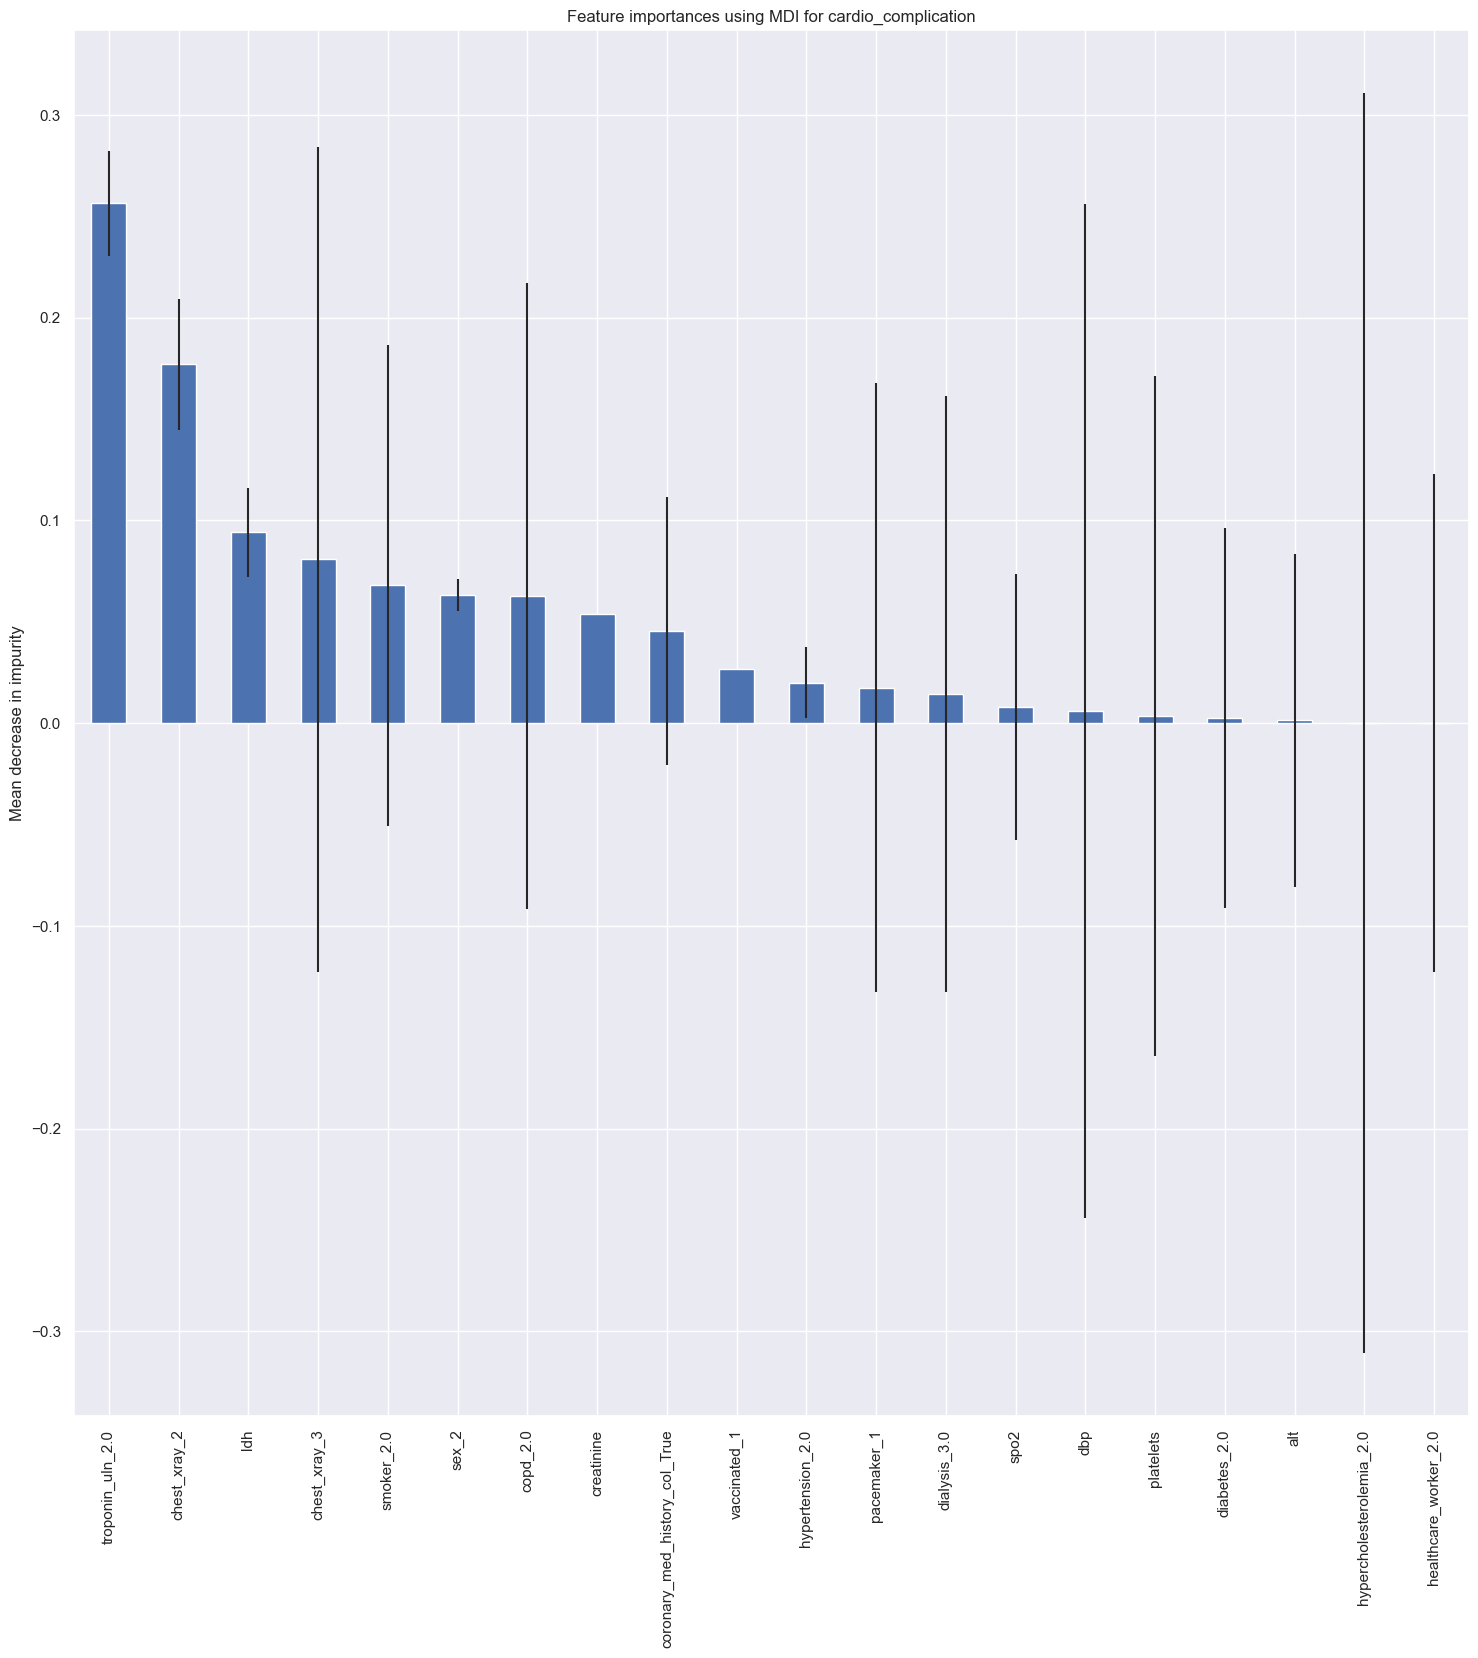

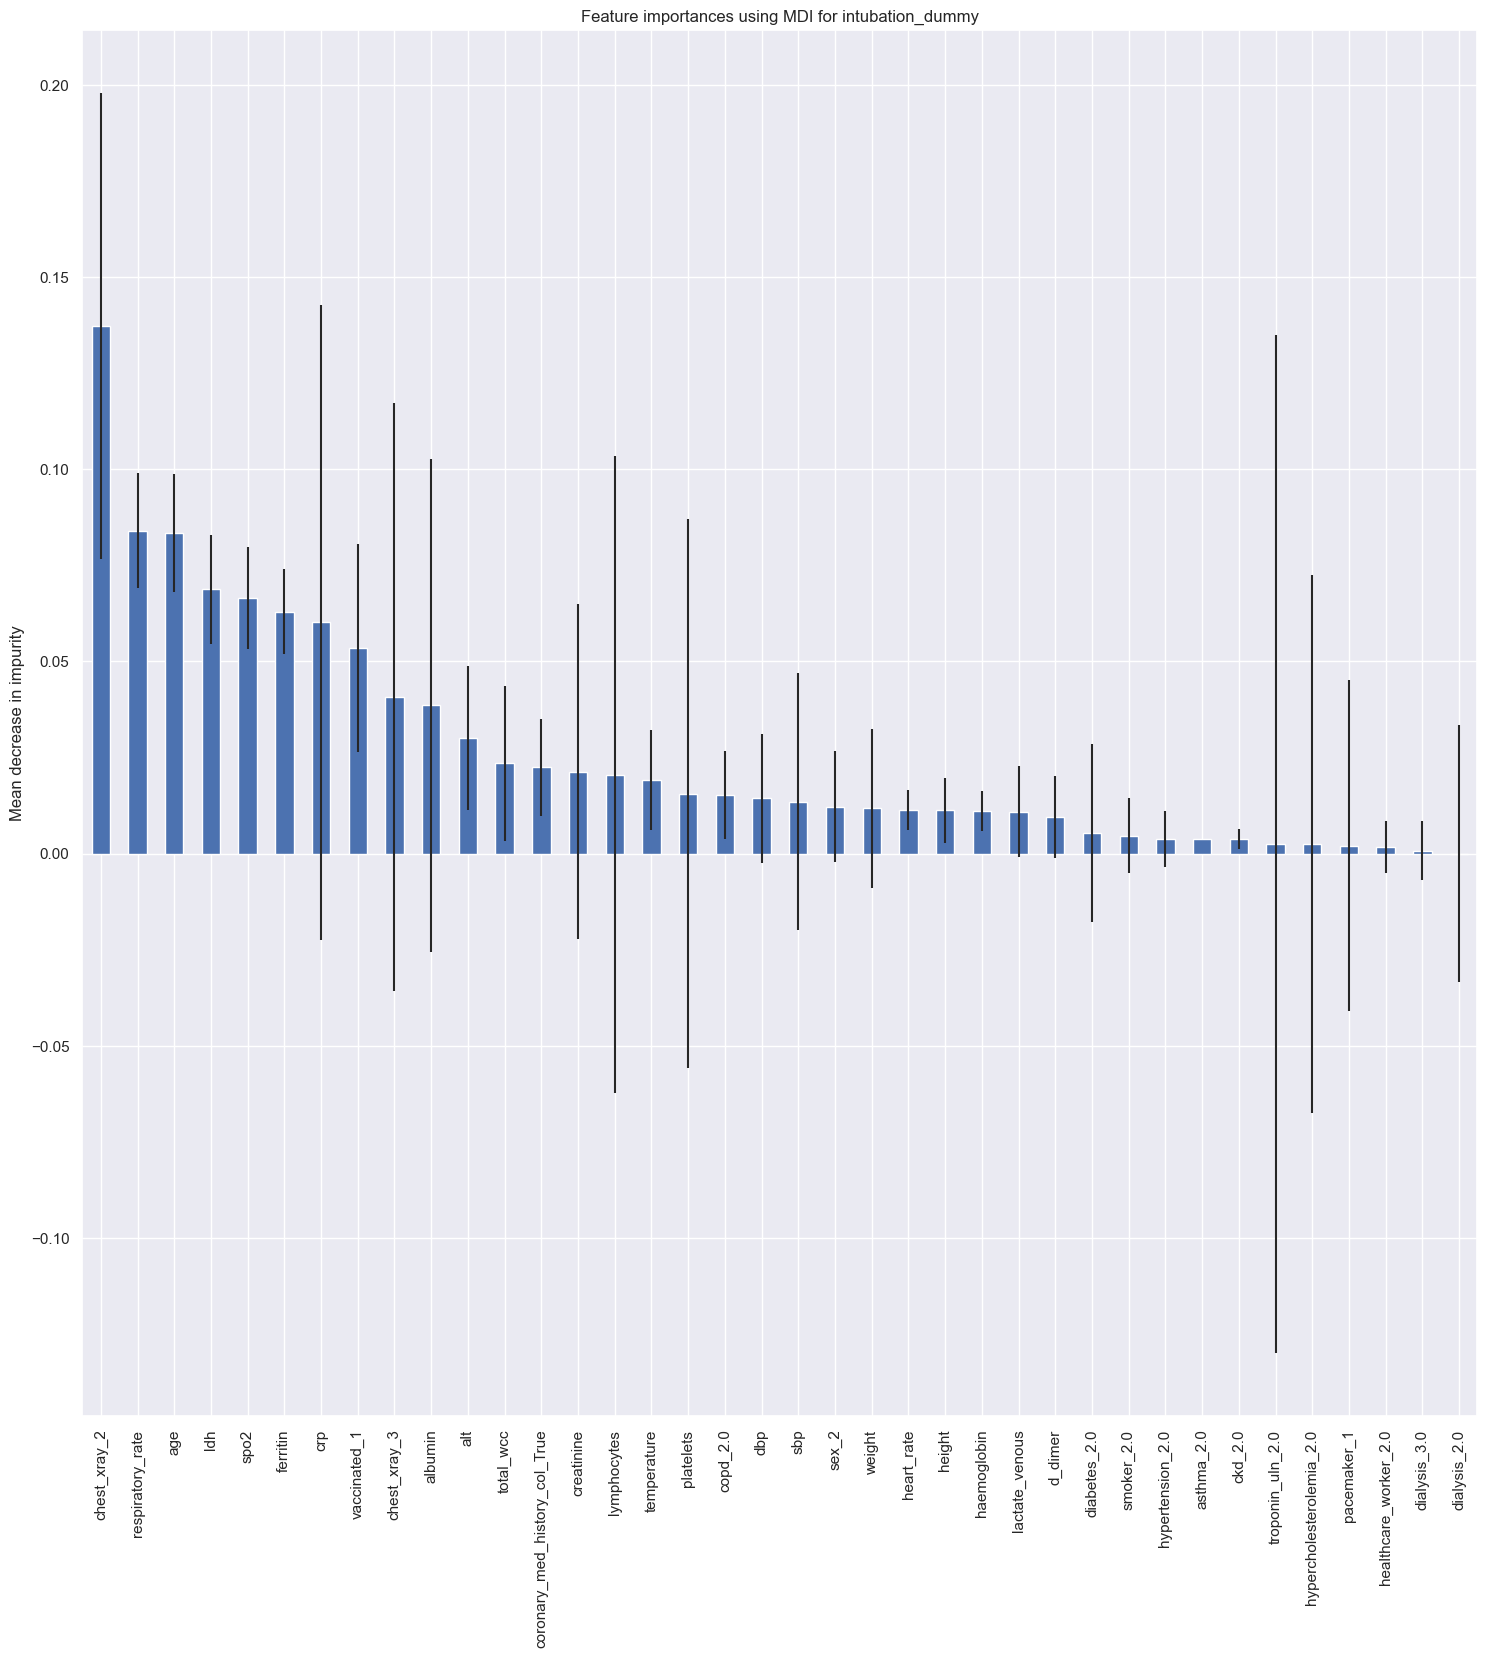

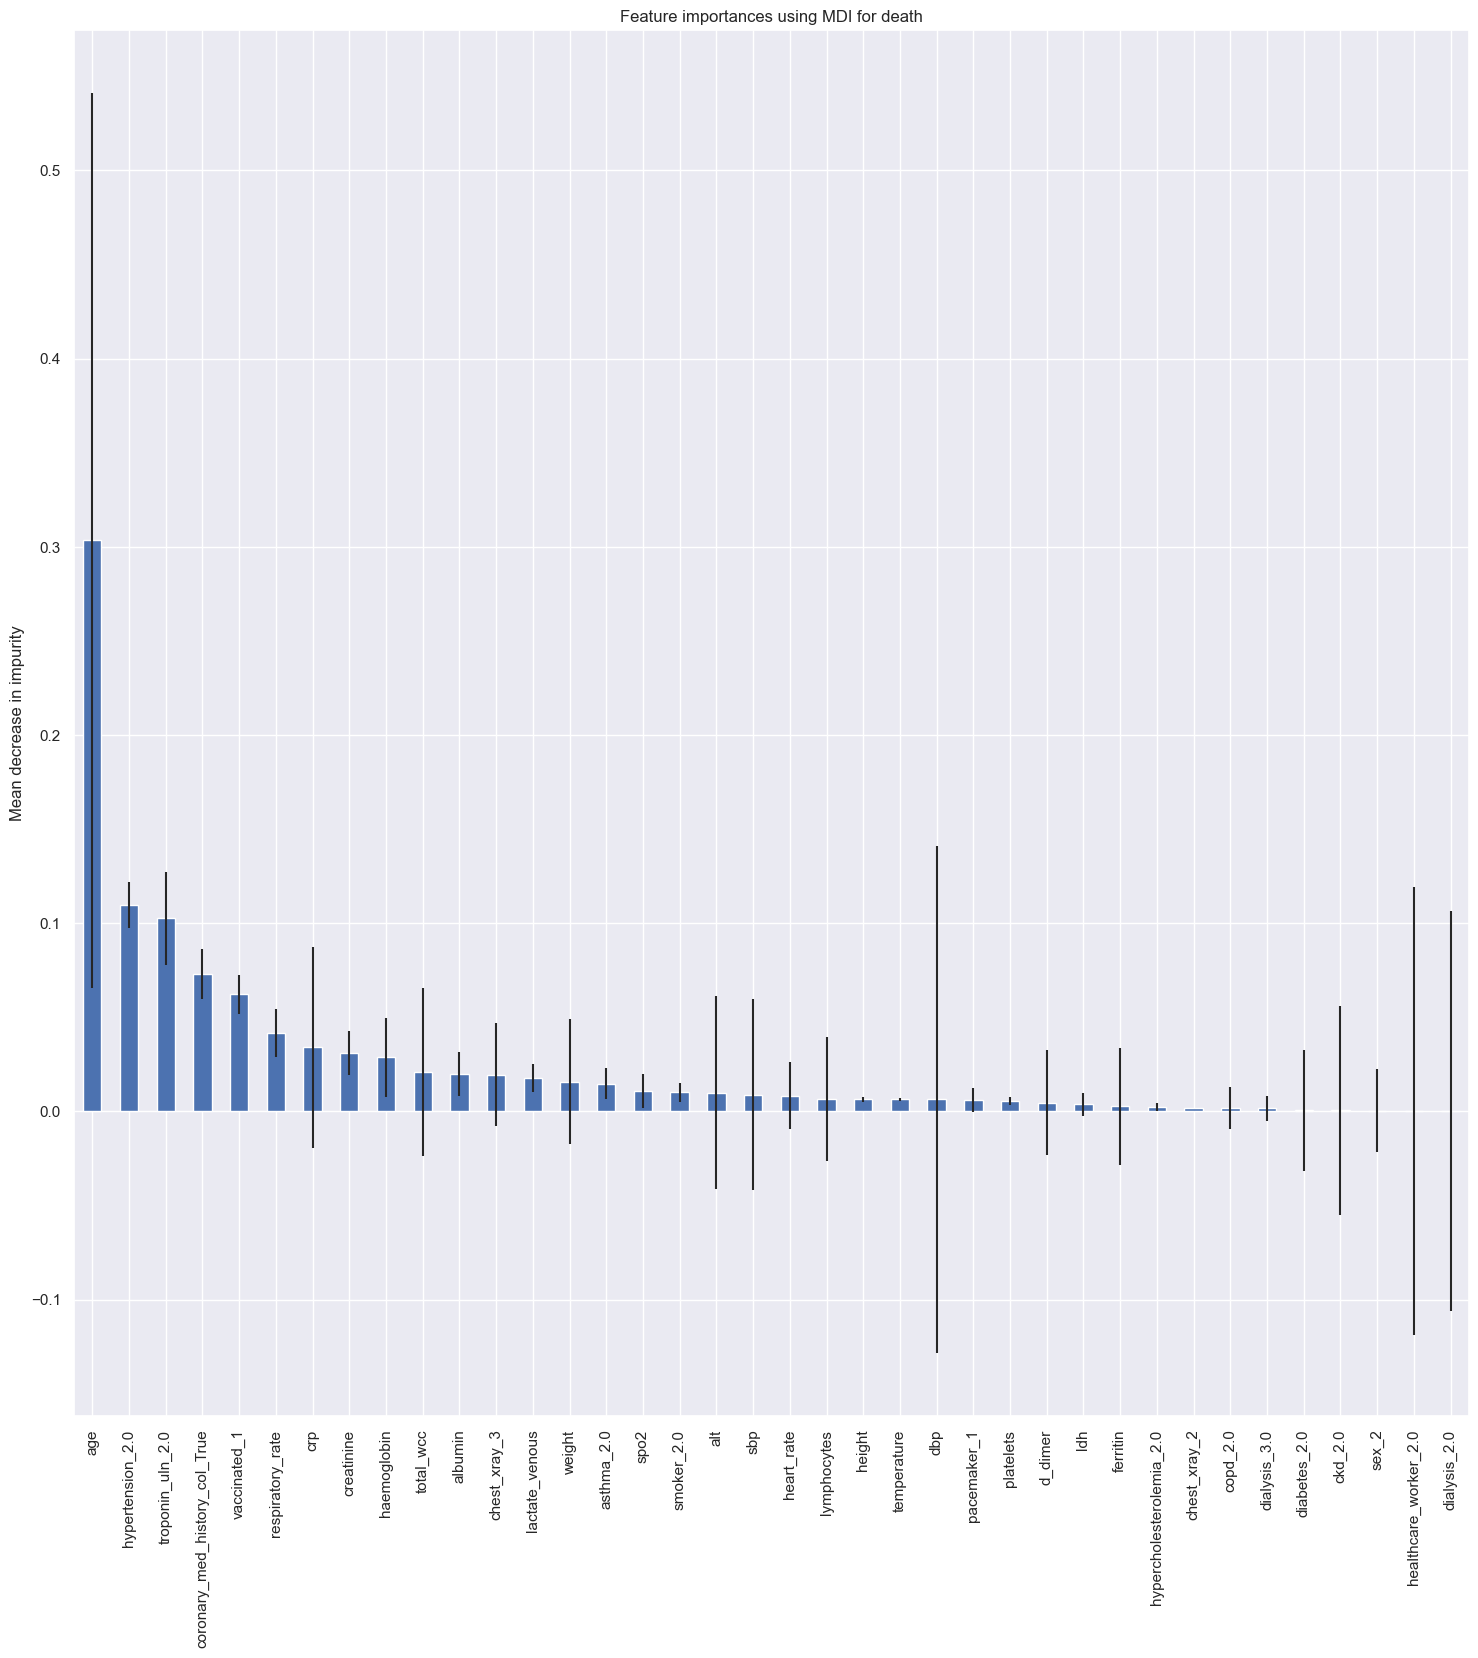

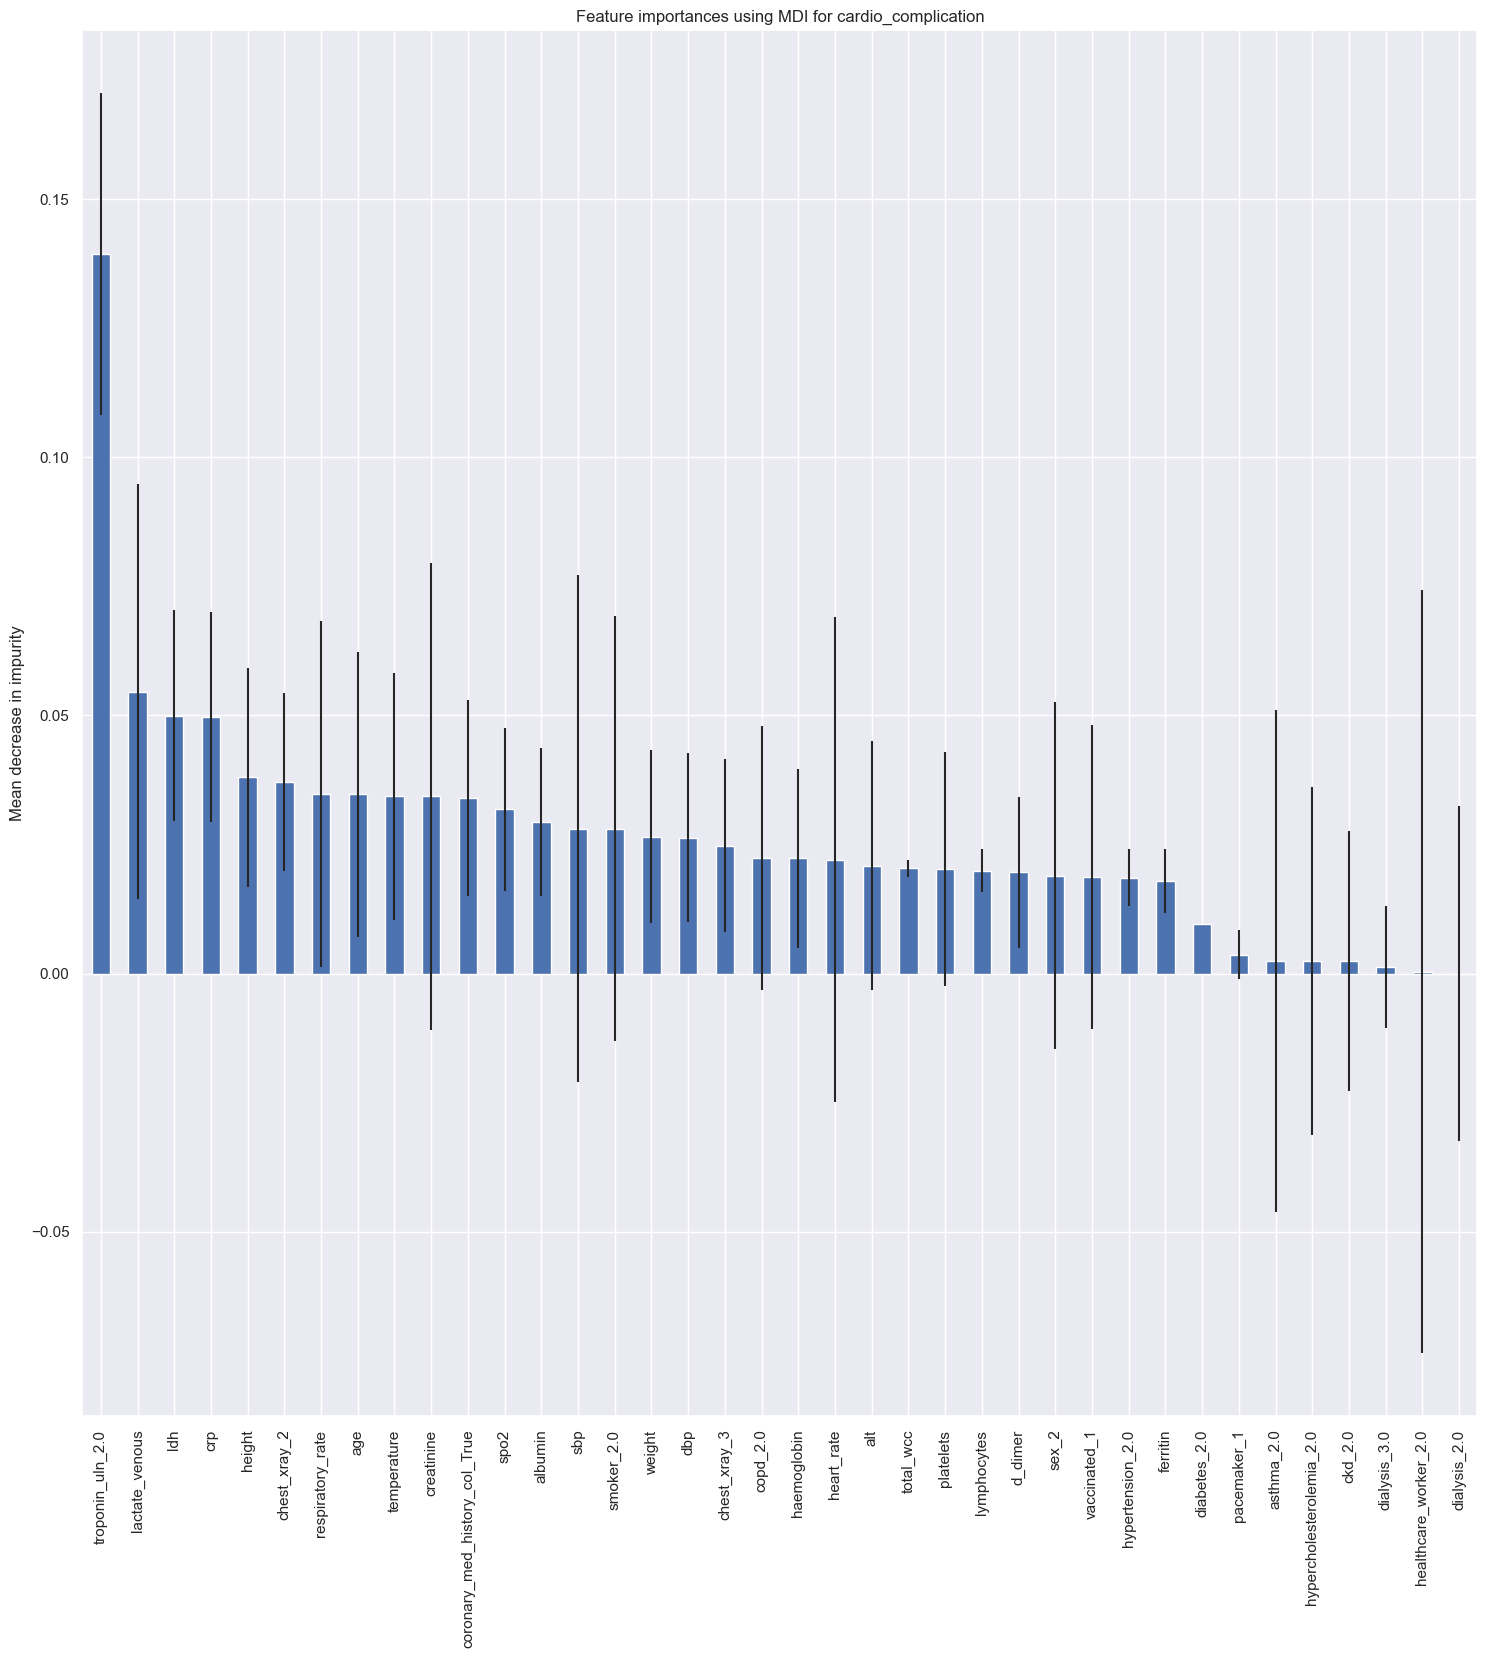

In [42]:
for n in n_features:
    for use_oversample in [True]:
        for p in predictor:
            if use_oversample:
                model_name = "rf_feature_selection" + str(n) +  "_oversample"
            else:
                model_name = "rf_feature_selection"  + str(n)
            loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")


            importances = loaded_pipe.named_steps["model"].feature_importances_
            std = np.std([tree.feature_importances_ for tree in loaded_pipe.named_steps["model"].estimators_], axis=0)
            y_train = train[p]
            X_train = train.drop(predictor, axis=1)
            if n != 'all':
                feature_select = loaded_pipe.named_steps["feature_select"].get_support()
                forest_importances = pd.Series(importances, index= X_train.columns[feature_select])
            else:
                forest_importances = pd.Series(importances, index= X_train.columns)
            forest_importances = forest_importances.sort_values(ascending=False)
            fig, ax = plt.subplots(figsize=(18, 18))
            forest_importances.plot.bar(yerr=std, ax=ax)
            ax.set_title("Feature importances using MDI for " + p)
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout

            plt.savefig("figure/" + model_name + "_coeff_" + p +".png",bbox_inches="tight")

## coefficient plots

In [42]:
def plot_coef(model,model_name,columns):
    
    if "feature_select" in model.named_steps:
        feature_select = model.named_steps["feature_select"].support_
        columns = columns[feature_select]
        
    coefs = model.named_steps["model"].coef_
    coef_df = pd.DataFrame(data = {'variable' : columns,
                          'value' : coefs[0],
                           'Magnitude':   coefs[0]    })

    coef_df = coef_df.sort_values('Magnitude', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="Magnitude")
    #ax.set_title("Coefficient for " + p)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(), rotation=45)

    plt.savefig("paper_figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    return ax

In [50]:
train_adj = train.rename(columns={
    'chest_xray_2': 'First chest Xray with COVID-19 features present',
    'coronary_med_history_col_True': 'Pre-existing cardiovascular disease',
    'sex_2': 'Female',
    'vaccinated_1': 'COVID-19 vaccination with 1 or more doses',
    'spo2':'SpO2%',
    'age':'Age',
    'respiratory_rate':'Respiratory rate',
    'chest_xray_3': 'First chest Xray with no features of COVID-19 present',
    'troponin_uln_2.0':'Troponin below upper limit of normal',
    'smoker_2.0': 'Not current nor recent smoker (<1 year)',
    'creatinine':'Creatinine',  
})

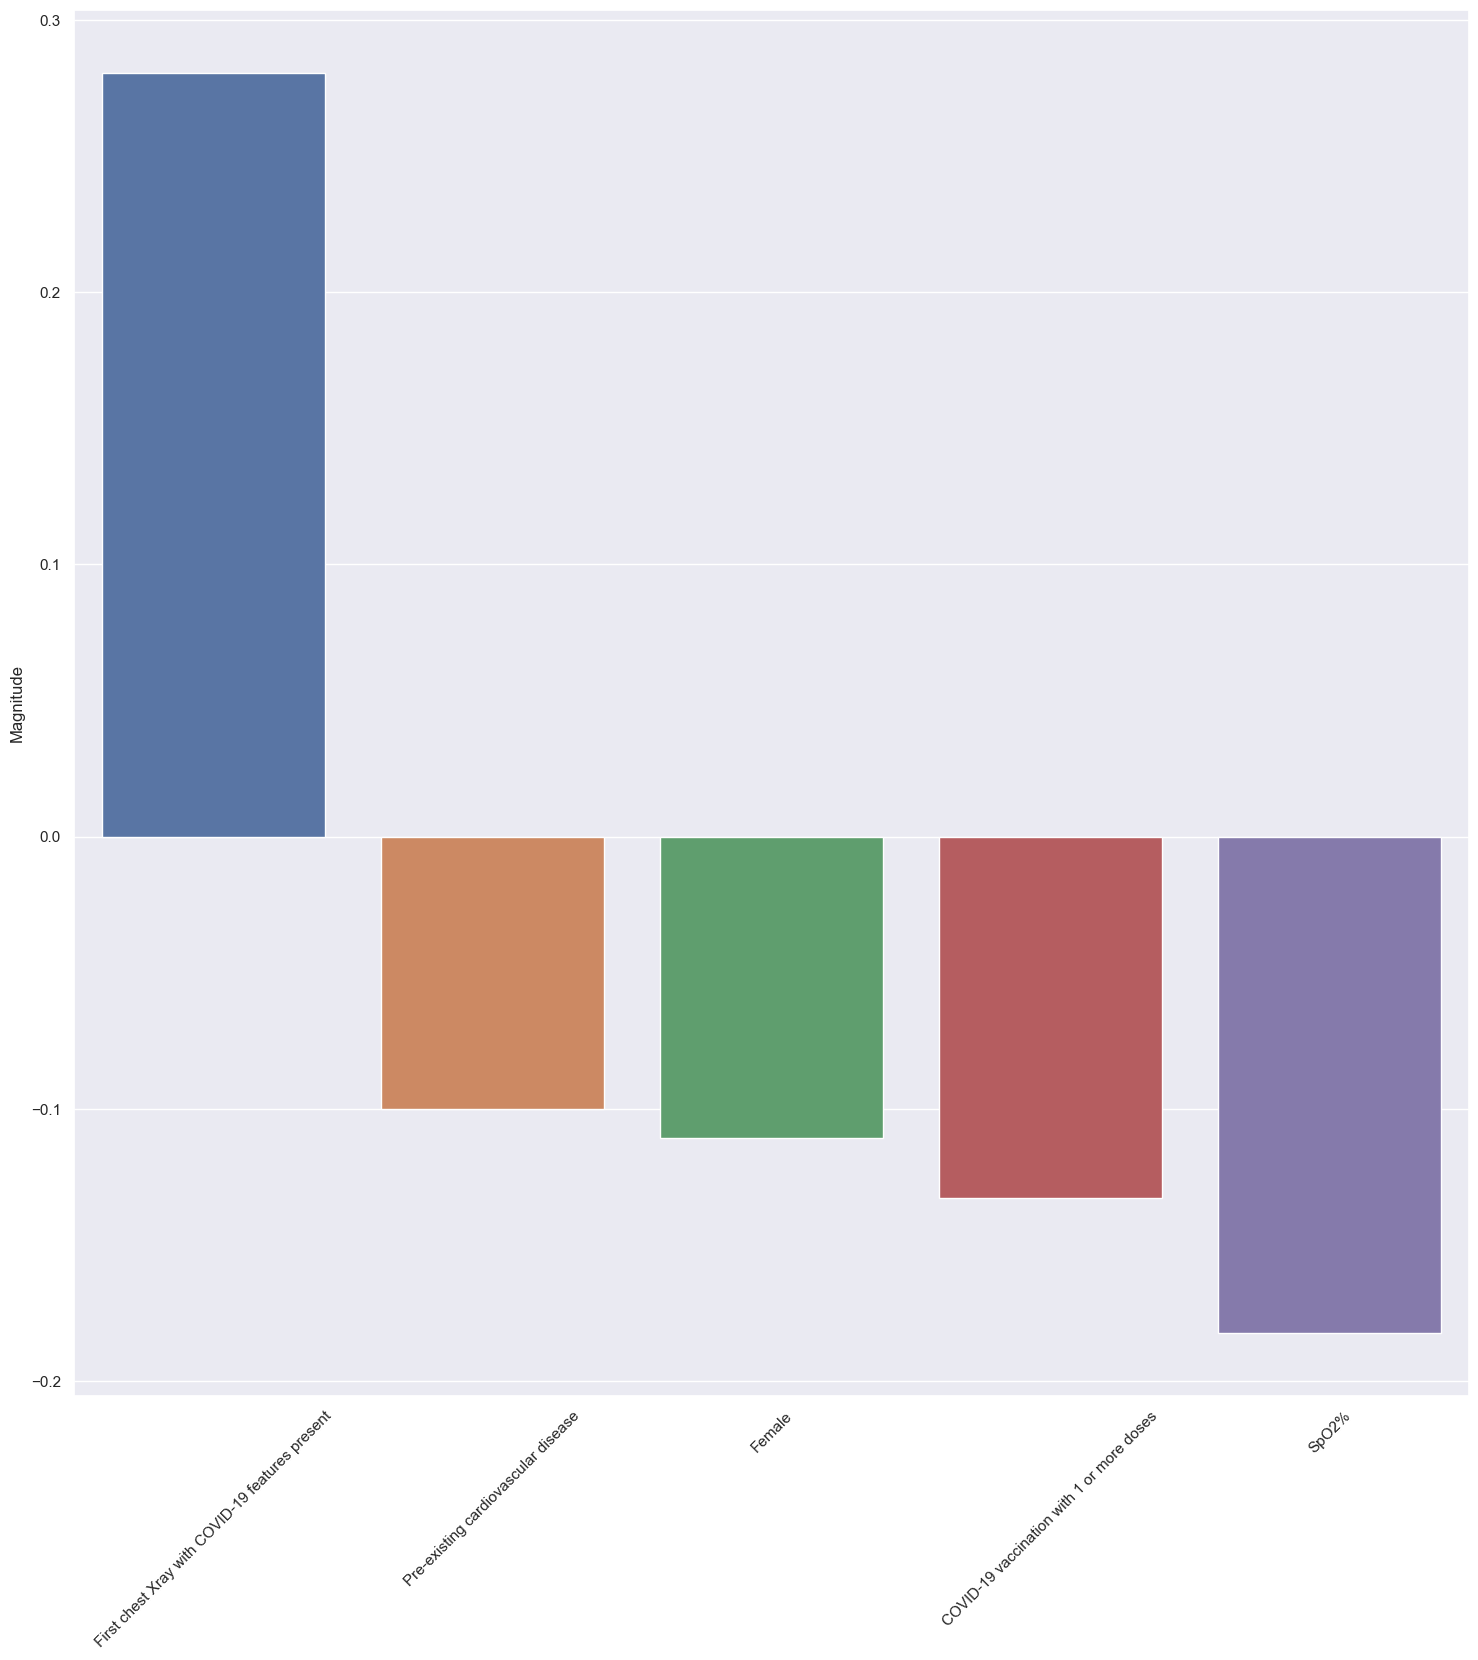

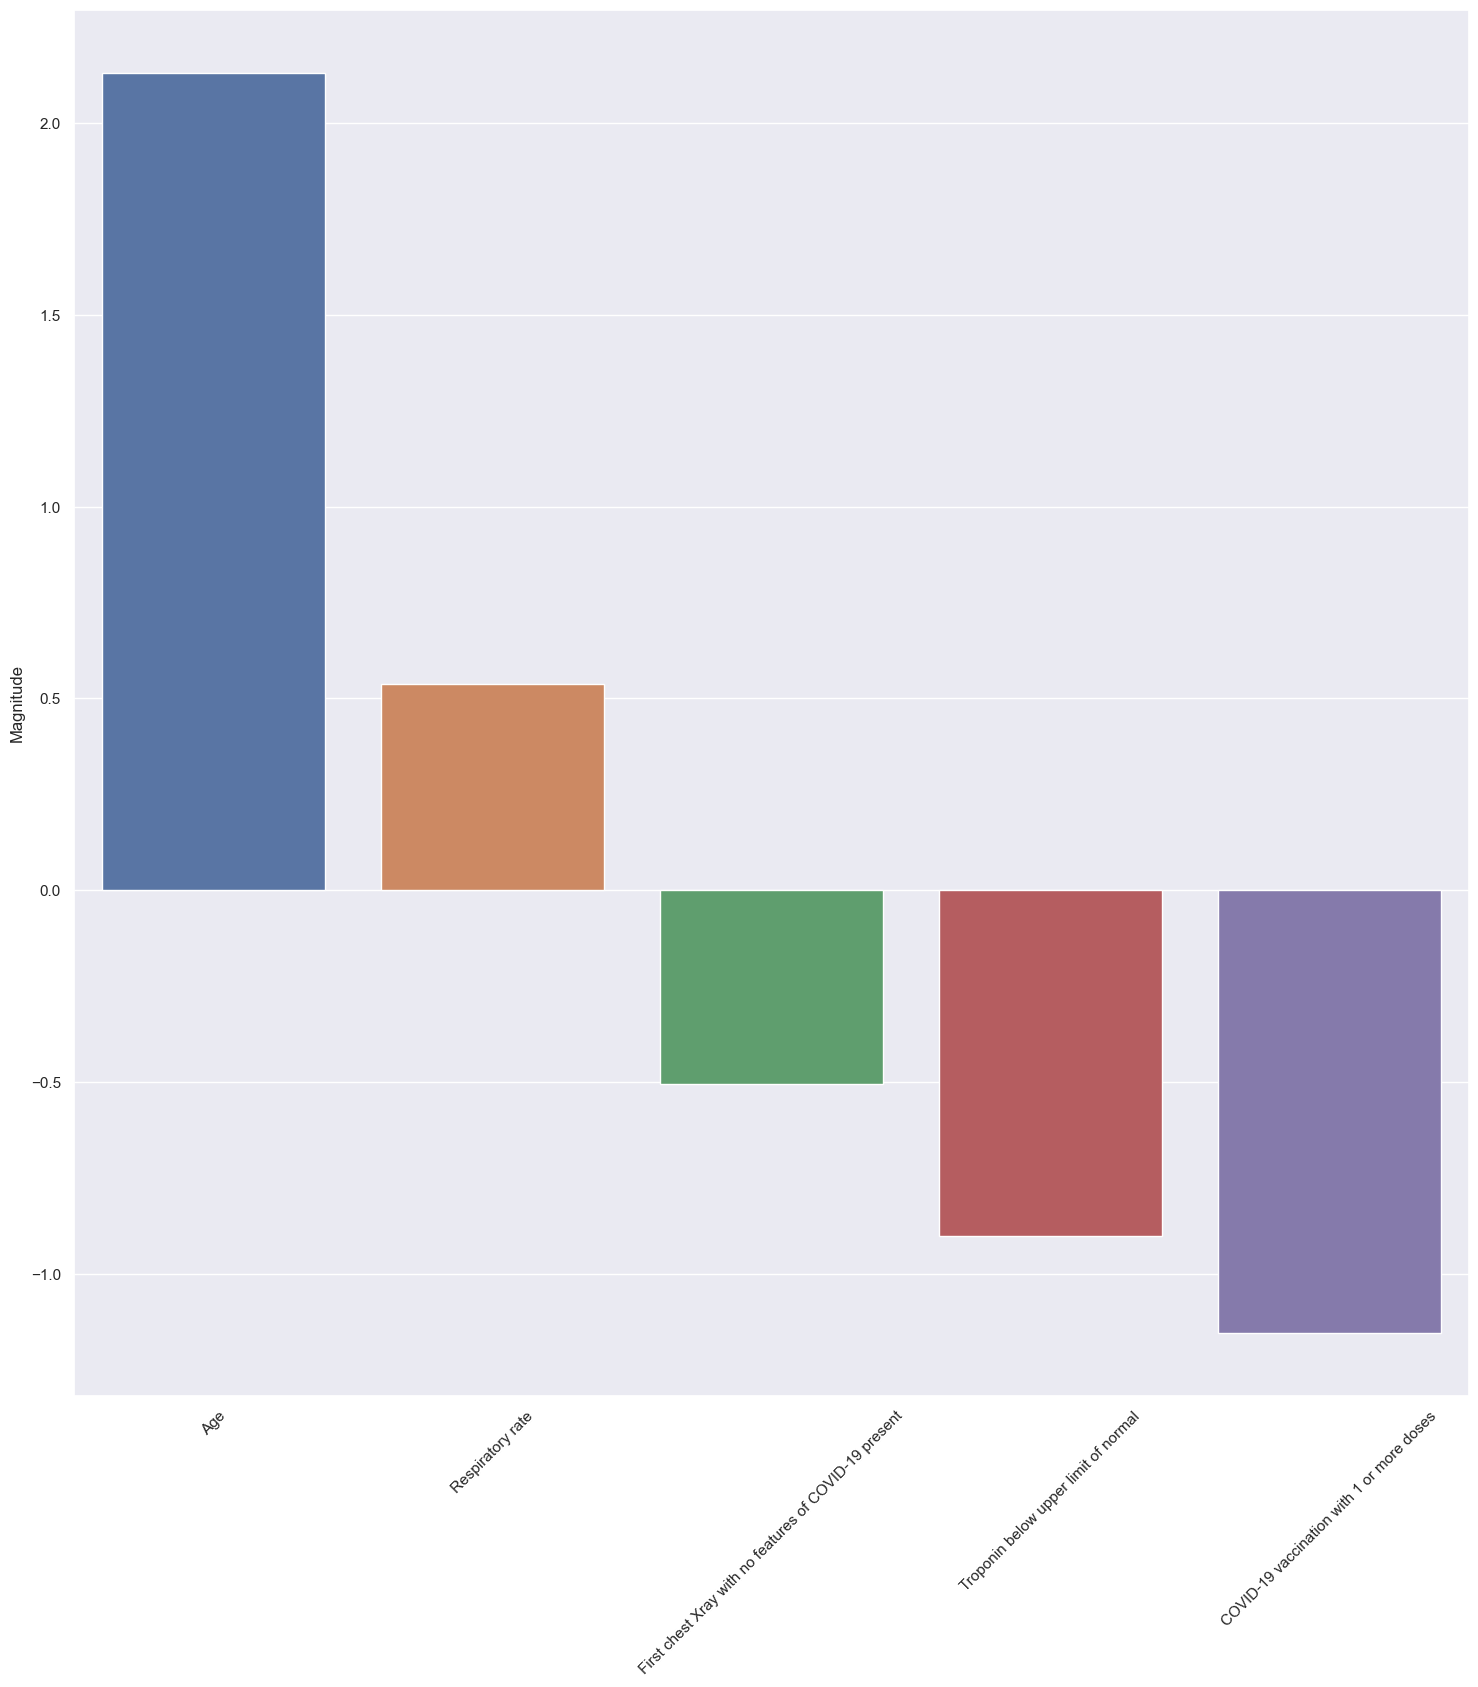

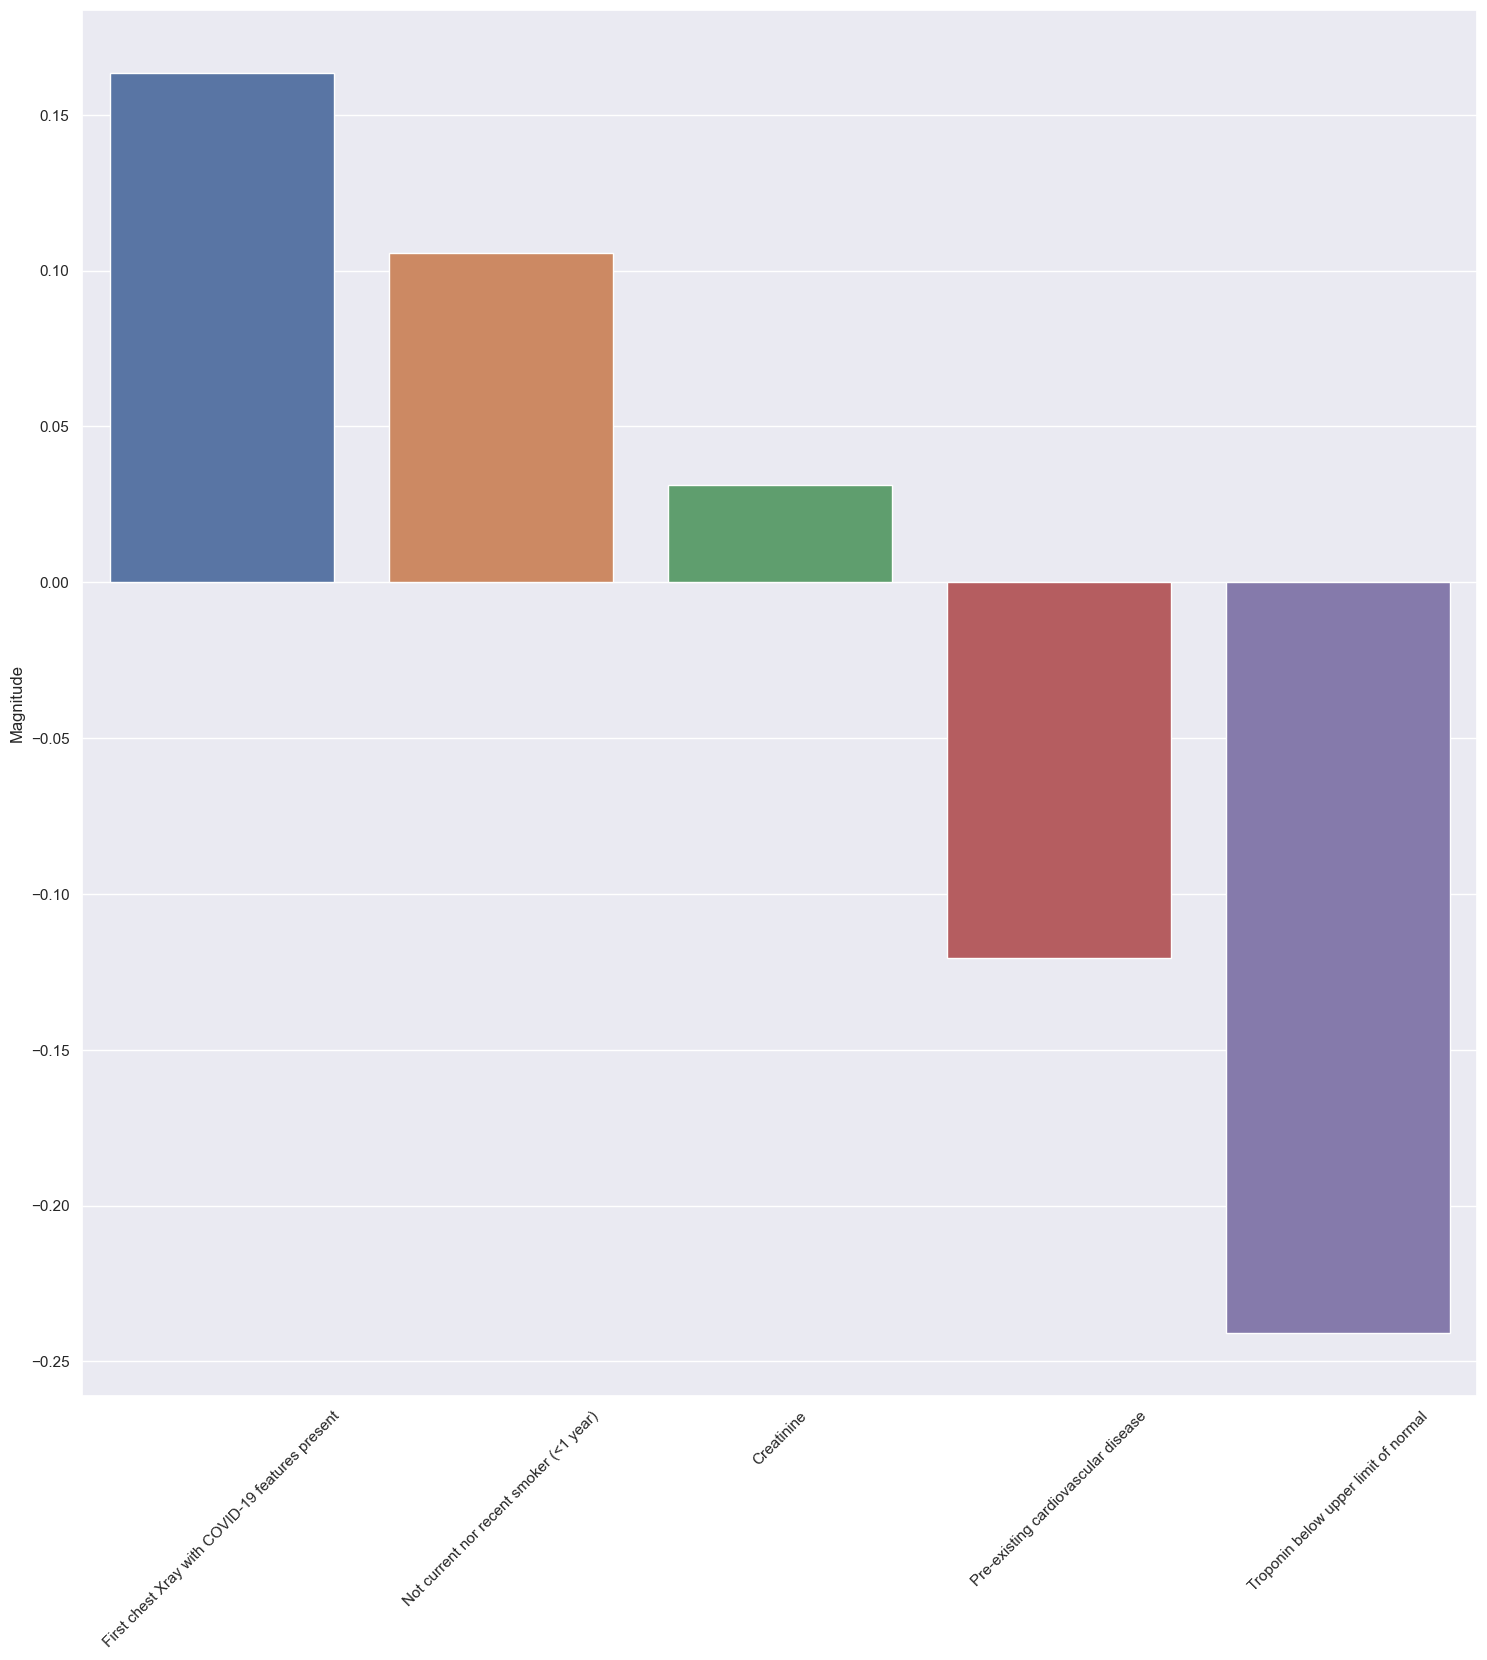

In [51]:
for p in predictor:
    model_name = chosen_model[p][0]
    test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    X_train = train_adj.drop(predictor,axis=1)
    plot_coef(test_pipe,model_name,X_train.columns)